<a href="https://colab.research.google.com/github/xRAFPx/AAII/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [464]:
# from google.colab import drive
# drive.mount('/content/drive')

In [465]:
import requests
import json
import csv
import string
import io
import pandas as pd
from tempfile import NamedTemporaryFile
import shutil
from datetime import date
import datetime
import os.path
from os import path
import re
import xlrd
import math
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from getpass import getpass
from functools import reduce
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Variáveis

Variáveis utilizadas no decorrer do trabalho

In [466]:
folder = '/content/drive/My Drive/Colab Notebooks/AII Project'
gitFolder = '/content/AAII/Data'
model_folder = folder + '/Model Output'

#Temperatura
norte_weather_filepath = folder + '/weather_norte.csv'
centro_weather_filepath = folder + '/weather_centro.csv'
lvt_weather_filepath = folder + '/weather_lvt.csv'
algarve_weather_filepath = folder + '/weather_algarve.csv'
alentejo_weather_filepath = folder + '/weather_alentejo.csv'

#Óbitos COVID-19
acores_death_filepath = folder + '/acores_death.csv'
madeira_death_filepath = folder + '/madeira_death.csv'
alentejo_death_filepath = folder + '/alentejo_death.csv'
algarve_death_filepath = folder + '/algarve_death.csv'
lvt_death_filepath = folder + '/lvt_death.csv'
centro_death_filepath = folder + '/centro_death.csv'
norte_death_filepath = folder + '/norte_death.csv'

#Casos Confirmados COVID-19
acores_filepath = folder + '/acores.csv'
madeira_filepath = folder + '/madeira.csv'
alentejo_filepath = folder + '/alentejo.csv'
algarve_filepath = folder + '/algarve.csv'
lvt_filepath = folder + '/lvt.csv'
centro_filepath = folder + '/centro.csv'
norte_filepath = folder + '/norte.csv'

#Modelos
best_fileSVR = model_folder + '/bestResults_SVR.csv'


In [467]:
if path.exists(folder):
  print("No directory error")
else:
  #Create a new directory (a folder) in your Drive
  os.mkdir(folder)
  print("Directory created")


No directory error


In [468]:
def read_dataset(url):
  df = pd.read_csv(url, parse_dates=[0], index_col=[0], infer_datetime_format=True)
  return df.fillna(value=0)

In [469]:
df_norte_aux = read_dataset(norte_filepath)
# pd.set_option('display.max_rows', df_norte.shape[0]+1)
# print(df_norte)
df_centro_aux = read_dataset(centro_filepath)
df_lvt_aux = read_dataset(lvt_filepath)
df_alentejo_aux = read_dataset(alentejo_filepath)
df_algarve_aux = read_dataset(algarve_filepath)
df_madeira_aux = read_dataset(madeira_filepath)
df_acores_aux = read_dataset(acores_filepath)

In [470]:
df_norte.shape

(116, 1)

In [471]:
df_acores_death = read_dataset(norte_filepath)
df_madeira_death = read_dataset(madeira_death_filepath)
df_alentejo_death = read_dataset(alentejo_death_filepath)
df_algarve_death = read_dataset(algarve_death_filepath)
df_lvt_death = read_dataset(lvt_death_filepath)
df_centro_death = read_dataset(centro_death_filepath)
df_norte_death = read_dataset(norte_death_filepath)

In [472]:
df_norte_weather = read_dataset(norte_weather_filepath)
df_centro_weather = read_dataset(centro_weather_filepath)
df_lvt_weather = read_dataset(lvt_weather_filepath)
df_algarve_weather = read_dataset(algarve_weather_filepath)
df_alentejo_weather = read_dataset(alentejo_weather_filepath)

Houve dias em que houve atualização dos dados de casos confirmados pelo que haviam dias com dados de novos casos negativos porque os novos casos naquele dia foram menores do que removidos. Ao obter a diferença dos dados cumulativos do COVID para cada dia com o dia anterior, há dias em que o valor é menor do que o do dia anterior, resultando em valores negativos de novos casos.

In [473]:
df_norte[df_norte<0]=0

In [474]:
df_centro[df_centro<0]=0

In [475]:
df_lvt_aux[df_lvt_aux<0]=0
df_alentejo_aux[df_alentejo_aux<0]=0
df_algarve_aux[df_algarve_aux<0]=0
df_acores_aux[df_acores_aux<0]=0
df_madeira_aux[df_madeira_aux<0]=0

# Preparação dos dados

Escalar os dados (os valores estarão entre 0 e 1) para aumentar a velocidade do treino e o desempenho do modelo. Como se trata de novos casos de COVID-19, não há valores negativos pelo que esta escala enfatiza esse facto.

In [476]:
def data_normalization(df):
  scaler = MinMaxScaler()
  df = scaler.fit_transform(df)
  return scaler, df

In [477]:
scaler_norte, df_norte = data_normalization(df_norte_aux)
scaler_centro, df_centro = data_normalization(df_centro_aux)
scaler_lvt, df_lvt = data_normalization(df_lvt_aux)
scaler_alentejo, df_alentejo = data_normalization(df_alentejo_aux)
scaler_algarve, df_algarve = data_normalization(df_algarve_aux)

In [478]:
df_norte.shape

(116, 1)

In [479]:
scaler_norte_death, df_norte_death = data_normalization(df_norte_death)
scaler_centro_death, df_centro_death = data_normalization(df_centro_death)
scaler_lvt_death, df_lvt_death = data_normalization(df_lvt_death)
scaler_alentejo_death, df_alentejo_death = data_normalization(df_alentejo_death)
scaler_algarve_death, df_algarve_death = data_normalization(df_algarve_death)

In [480]:
scaler_norte_weather, df_norte_weather = data_normalization(df_norte_weather)
scaler_centro_weather, df_centro_weather = data_normalization(df_centro_weather)
scaler_lvt_weather, df_lvt_weather = data_normalization(df_lvt_weather)
scaler_alentejo_weather, df_alentejo_weather = data_normalization(df_alentejo_weather)
scaler_algarve_weather, df_algarve_weather = data_normalization(df_algarve_weather)

Numa primeira fase, a análise foi univariada, isto é, apenas a *feature* relativa aos novos casos confirmados está envolvida no treino e posterior previsão.
Procedi então à construção de um modelo supervisionado em que a cada 4 dias (X; preditor) têm como preditivo (y) o próximo dia.

In [481]:
def build_supervised(df, timesteps):
	data = df
	X, y = list(), list()
	dataset_size = len(data)
	for curr_pos in range(dataset_size):
		input_index =  curr_pos + timesteps
		label_index = input_index + 1
		if label_index <= dataset_size:
			X.append(data[curr_pos:input_index, :])
			y.append(data[input_index:label_index, 0])
	return np.array(X).astype('float32'), np.array(y).astype('float32')

In [482]:
timesteps = 4

In [483]:
X_norte, y_norte = build_supervised(df_norte, timesteps)
X_centro, y_centro = build_supervised(df_centro, timesteps)
X_lvt, y_lvt = build_supervised(df_lvt, timesteps)
X_alentejo, y_alentejo = build_supervised(df_alentejo, timesteps)
X_algarve, y_algarve = build_supervised(df_algarve, timesteps)

Criar as estruturas de treino, teste e validação do modelo com 10% para teste, 10% para validação e os restantes 80% para treino. Para ter uma estrutura de dados com todos os dados exceto os de teste para otimizar os dados, visto que temos poucos dias de dados, criei outra estrutura com os dados de treino e de validação.

In [484]:
valid_test_percent = 0.1
df_region_valid_test_size = int(np.round(valid_test_percent * X_norte.shape[0]))
df_region_train_size = X_norte.shape[0] - df_region_valid_test_size*2

In [485]:
df_region_valid_test_size

11

In [486]:
df_region_train_size

90

In [487]:
X_train_norte = X_norte[:df_region_train_size]
y_train_norte = y_norte[:df_region_train_size]

X_train_centro = X_centro[:df_region_train_size]
y_train_centro = y_centro[:df_region_train_size]

X_train_lvt = X_lvt[:df_region_train_size]
y_train_lvt = y_lvt[:df_region_train_size]

X_train_algarve = X_algarve[:df_region_train_size]
y_train_algarve = y_algarve[:df_region_train_size]

X_train_alentejo = X_alentejo[:df_region_train_size]
y_train_alentejo = y_alentejo[:df_region_train_size]

In [488]:
X_test_norte = X_norte[df_region_train_size + df_region_valid_test_size :]
y_test_norte = y_norte[df_region_train_size + df_region_valid_test_size :]

X_test_centro = X_centro[df_region_train_size + df_region_valid_test_size :]
y_test_centro = y_centro[df_region_train_size + df_region_valid_test_size :]

X_test_lvt = X_lvt[df_region_train_size + df_region_valid_test_size :]
y_test_lvt = y_lvt[df_region_train_size + df_region_valid_test_size :]

X_test_algarve = X_algarve[df_region_train_size + df_region_valid_test_size :]
y_test_algarve = y_algarve[df_region_train_size + df_region_valid_test_size :]

X_test_alentejo = X_alentejo[df_region_train_size + df_region_valid_test_size :]
y_test_alentejo = y_alentejo[df_region_train_size + df_region_valid_test_size :]

In [489]:
X_val_norte = X_norte[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_norte = y_norte[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_centro = X_centro[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_centro = y_centro[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_lvt = X_lvt[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_lvt = y_lvt[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_algarve = X_algarve[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_algarve = y_algarve[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_alentejo = X_alentejo[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_alentejo = y_alentejo[df_region_train_size:df_region_train_size + df_region_valid_test_size]

In [490]:
X_train_val_norte = X_norte[:df_region_train_size + df_region_valid_test_size]
y_train_val_norte = y_norte[:df_region_train_size + df_region_valid_test_size]

X_train_val_centro = X_centro[:df_region_train_size + df_region_valid_test_size]
y_train_val_centro = y_centro[:df_region_train_size + df_region_valid_test_size]

X_train_val_lvt = X_lvt[:df_region_train_size + df_region_valid_test_size]
y_train_val_lvt = y_lvt[:df_region_train_size + df_region_valid_test_size]

X_train_val_algarve = X_algarve[:df_region_train_size + df_region_valid_test_size]
y_train_val_algarve = y_algarve[:df_region_train_size + df_region_valid_test_size]

X_train_val_alentejo = X_alentejo[:df_region_train_size + df_region_valid_test_size]
y_train_val_alentejo = y_alentejo[:df_region_train_size + df_region_valid_test_size]

In [491]:
#80% dos dados iniciais para o treino da SARIMA
df_norte_aux_train = df_norte_aux.iloc[:df_region_train_size + df_region_valid_test_size]
df_centro_aux_train = df_centro_aux.iloc[:df_region_train_size + df_region_valid_test_size] 
df_lvt_aux_train = df_lvt_aux.iloc[:df_region_train_size + df_region_valid_test_size]
df_algarve_aux_train = df_algarve_aux.iloc[:df_region_train_size + df_region_valid_test_size]
df_alentejo_aux_train = df_alentejo_aux.iloc[:df_region_train_size + df_region_valid_test_size]

#20% dos dados iniciais para o teste da SARIMA
df_norte_aux_test = df_norte_aux.iloc[df_region_train_size + df_region_valid_test_size :]
df_centro_aux_test = df_centro_aux.iloc[df_region_train_size + df_region_valid_test_size :]
df_lvt_aux_test = df_lvt_aux.iloc[df_region_train_size + df_region_valid_test_size :]
df_algarve_aux_test = df_algarve_aux.iloc[df_region_train_size + df_region_valid_test_size :]
df_alentejo_aux_test = df_alentejo_aux.iloc[df_region_train_size + df_region_valid_test_size :]

In [492]:
print(X_train_norte.shape)
print(y_train_norte.shape)

print(X_test_norte.shape)
print(y_test_norte.shape)

print(X_val_norte.shape)
print(y_val_norte.shape)

print(X_train_val_norte.shape)
print(y_train_val_norte.shape)

(90, 4, 1)
(90, 1)
(11, 4, 1)
(11, 1)
(11, 4, 1)
(11, 1)
(101, 4, 1)
(101, 1)


**Dia 20 de junho de 2020**

> Os dados do COVID-19 começaram a ser partilhados a partir da Quarta-feira, 26 de Fevereiro de 2020.


>Até ao dia 20 de junho (incluído) são 116 dias.




Como são 116 dias de dados do COVID-19 faz com que sejam 112 grupos de 4 dias => 116/4 = 29; 29-1 = 28; 28*4=112

* Treino => 80% de 112 = 90

* Teste => 10% de 112 = 11

* Validação => 10% de 112 = 11

90 + 11 + 11 = 112 grupos de 4 dias


Para que os dados tivessem a estrutura (número de elementos, timesteps) tive que fazer o reshape dos mesmos. Esta estrutura é importante para o modelo conseguir ler os dados.

In [493]:
X_train_norte_re = X_train_norte.reshape(X_train_norte.shape[0], X_train_norte.shape[1])
y_train_norte_re = y_train_norte.reshape(y_train_norte.shape[0],)

X_test_norte_re = X_test_norte.reshape(X_test_norte.shape[0], X_test_norte.shape[1])
y_test_norte_re = y_test_norte.reshape(y_test_norte.shape[0],)

X_val_norte_re = X_val_norte.reshape(X_val_norte.shape[0], X_val_norte.shape[1])
y_val_norte_re = y_val_norte.reshape(y_val_norte.shape[0],)

X_train_val_norte_re = X_train_val_norte.reshape(X_train_val_norte.shape[0], X_train_val_norte.shape[1])
y_train_val_norte_re = y_train_val_norte.reshape(y_train_val_norte.shape[0],)

In [494]:
X_train_norte.shape

(90, 4, 1)

In [495]:
X_train_norte_re.shape

(90, 4)

In [496]:
X_train_centro_re = X_train_centro.reshape(X_train_centro.shape[0], X_train_centro.shape[1])
y_train_centro_re = y_train_centro.reshape(y_train_centro.shape[0],)

X_test_centro_re = X_test_centro.reshape(X_test_centro.shape[0], X_test_centro.shape[1])
y_test_centro_re = y_test_centro.reshape(y_test_centro.shape[0],)

X_val_centro_re = X_val_centro.reshape(X_val_centro.shape[0], X_val_centro.shape[1])
y_val_centro_re = y_val_centro.reshape(y_val_centro.shape[0],)

X_train_val_centro_re = X_train_val_centro.reshape(X_train_val_centro.shape[0], X_train_val_centro.shape[1])
y_train_val_centro_re = y_train_val_centro.reshape(y_train_val_centro.shape[0],)

In [497]:
X_train_lvt_re = X_train_lvt.reshape(X_train_lvt.shape[0], X_train_lvt.shape[1])
y_train_lvt_re = y_train_lvt.reshape(y_train_lvt.shape[0],)

X_test_lvt_re = X_test_lvt.reshape(X_test_lvt.shape[0], X_test_lvt.shape[1])
y_test_lvt_re = y_test_lvt.reshape(y_test_lvt.shape[0],)

X_val_lvt_re = X_val_lvt.reshape(X_val_lvt.shape[0], X_val_lvt.shape[1])
y_val_lvt_re = y_val_lvt.reshape(y_val_lvt.shape[0],)

X_train_val_lvt_re = X_train_val_lvt.reshape(X_train_val_lvt.shape[0], X_train_val_lvt.shape[1])
y_train_val_lvt_re = y_train_val_lvt.reshape(y_train_val_lvt.shape[0],)

In [498]:
X_train_algarve_re = X_train_algarve.reshape(X_train_algarve.shape[0], X_train_algarve.shape[1])
y_train_algarve_re = y_train_algarve.reshape(y_train_algarve.shape[0],)

X_test_algarve_re = X_test_algarve.reshape(X_test_algarve.shape[0], X_test_algarve.shape[1])
y_test_algarve_re = y_test_algarve.reshape(y_test_algarve.shape[0],)

X_val_algarve_re = X_val_algarve.reshape(X_val_algarve.shape[0], X_val_algarve.shape[1])
y_val_algarve_re = y_val_algarve.reshape(y_val_algarve.shape[0],)

X_train_val_algarve_re = X_train_val_algarve.reshape(X_train_val_algarve.shape[0], X_train_val_algarve.shape[1])
y_train_val_algarve_re = y_train_val_algarve.reshape(y_train_val_algarve.shape[0],)

In [499]:
X_train_alentejo_re = X_train_alentejo.reshape(X_train_alentejo.shape[0], X_train_alentejo.shape[1])
y_train_alentejo_re = y_train_alentejo.reshape(y_train_alentejo.shape[0],)

X_test_alentejo_re = X_test_alentejo.reshape(X_test_alentejo.shape[0], X_test_alentejo.shape[1])
y_test_alentejo_re = y_test_alentejo.reshape(y_test_alentejo.shape[0],)

X_val_alentejo_re = X_val_alentejo.reshape(X_val_alentejo.shape[0], X_val_alentejo.shape[1])
y_val_alentejo_re = y_val_alentejo.reshape(y_val_alentejo.shape[0],)

X_train_val_alentejo_re = X_train_val_alentejo.reshape(X_train_val_alentejo.shape[0], X_train_val_alentejo.shape[1])
y_train_val_alentejo_re = y_train_val_alentejo.reshape(y_train_val_alentejo.shape[0],)

#Introdução ao problema

COVID-19 é um vírus que atingiu a China em dezembro de 2019 e tornou-se uma pandemia poucos meses depois ao infetar milhões de pessoas por todo o mundo.
Em Portugal, a DGS começou a partilhar os relatórios com os dados de infetados em Portugal a partir do dia 26 de fevereiro de 2020. 

Uma divisão do problema em regiões faz com que tendências de cada região sejam aprendidas, resultando numa melhor abordagem na previsão de novos casos de COVID. A região do Alentejo, por exemplo, tem tido um desenvolvimento da pandemia completamente diferente da região de Lisboa e Vale do Tejo, tendo menos novos casos diariamente e menos mortes.

Numa primeira fase, a análise foi univariada, isto é, apenas a feature relativa aos novos casos confirmados está envolvida no treino e posterior previsão. Procedi então à construção de um modelo supervisionado em que a cada 4 dias (X; preditor) têm como preditivo (y) o próximo dia.
Numa segunda fase será feita uma análise multivariada com os dados das mortes por COVID e de temperatura máxima e mínima como preditores para os dados de casos confirmados de COVID por serem dados relevantes para o aumento ou diminuição do número de casos.


Foram feitas previsões para cada um dos modelos de forma a analisar o seu comportamento.
Como se trata de encontrar modelos que encontrem um melhor resultado em termos de aproximação de resultados, a medida a analisar será o erro (MSE). A *accuracy*, se fosse a medida a considerar, resultava em modelos com um alto ajuste (overfitting) aos dados de treino, não sendo bem a generalizar e a fazer previsões por serem usados novos dados porque a *accuracy* mede a frequência de previsões que são iguais ao preditivo (label).
O erro, ao analisar a diferença entre os dados previtos e os reais (label), permite que haja uma diferença entre os dados.



# Univariada

Na análise univariada foram analisados os modelos SARIMA, SVR e RNN (LSTM, GRU e SimpleRNN).

Para cada região foi construído um modelo que representa os dados da mesma.


##**ARIMA**

Estacionário significa apenas que as estatísticas do modelo não mudam com o tempo (estacionário "local"). Os modelos ARMA são essencialmente modelos de regressão em que são usados os N valores anteriores como entrada para a regressão linear para prever o valor N + 1 (AR). Quando o modelo está na fase de aprendizagem/treino, este está a aprender os coeficientes de regressão. 
Se for usada uma série temporal em que aprende o relacionamento entre os N pontos passados ​​e o próximo ponto, e depois aplica-o a um conjunto diferente de N pontos para prever o próximo valor, está implicitamente assumindo que o mesmo relacionamento se mantém entre os N pontos preditores e o N + 1 ponto a seguir que estamos a tentar prever (preditivo) (estacionariedade).

Este problema da estacionariedade aparece se, por exemplo, o conjunto de treino for separado em dois intervalos e cada parte fosse treinada separadamente e o modelo obtive-se dois modelos muitos diferentes. 

Isto afeta mais modelos como o ARMA em que os dados têm que ser estacionários, no entanto, o ARIMA, que é uma generalização dos modelos ARMA, a secção I (Integrated) signfica que um passo inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicado uma ou mais vezes para eliminar a não estacionariedade.
A parte auto-regressiva (AR) do modelo ARIMA indica que a variável evoluinte de interesse é regressada em seus próprios valores defasados, isto é, anteriores. A parte de média móvel (MA) indica que o erro de regressão é na verdade uma combinação linear dos termos de erro, cujos valores ocorreram contemporaneamente e em vários momentos no passado. A parte integrada (I) indica que os valores de dados foram substituídos com a diferença entre seus valores e os valores anteriores e este processo diferenciador pode ter sido realizado mais de uma vez. O propósito da cada uma destas características é fazer o modelo se ajustar aos dados da melhor forma possível.

Modelos ARIMA não sazonais são geralmente denotados como ARIMA(p,d,q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de defasagens) do modelo auto-regressivo, d é o grau de diferenciação (o número de vezes em que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. 
Dessa forma, um modelo ARMA(p,q) é um modelo ARIMA(p,0,q).

Mesmo que o modelo ARIMA consiga trabalhar sobre dados não estacionários, segui a fazer numa primeira fase uma análise para cada uma das regiões se os dados seriam, ou não, estacionários. Como o ARIMA é um modelo usado em problema univariados, toda a análise será feita nesta secção.


In [13]:
def seasonal_decomposition(df):
  decomposition = seasonal_decompose(df)

  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.figure(figsize=(12,8))

  plt.subplot(411)
  plt.plot(df, label='Original', color='blue')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend', color='blue')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal,label='Seasonality', color='blue')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.tight_layout()

  return seasonal, trend

In [14]:
def dickerFuller_test(df):
  #Determing rolling statistics
  #7 days
  rol_mean = df.rolling(window=7, center = False).mean()
  rol_std = df.rolling(window=7, center = False).std()

  #Plot rolling statistics:
  orig = plt.plot(df, color='blue',label='Original')
  mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
  std = plt.plot(rol_std, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  print("Perform Dickey-Fuller test")
  dftest = adfuller(df[df.columns[0]])
  #print test


  # to make the results of the test more readable
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

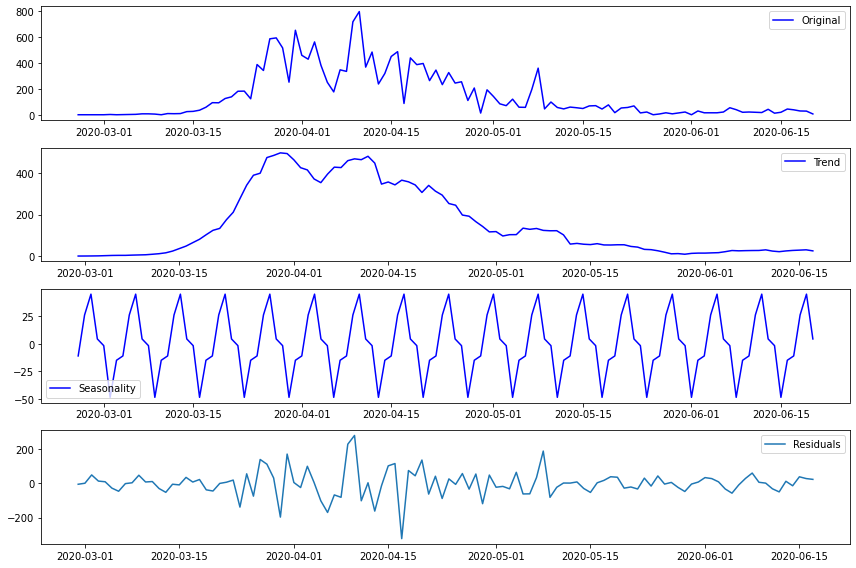

In [15]:
seasonal_norte,trend_norte=seasonal_decomposition(df_norte)

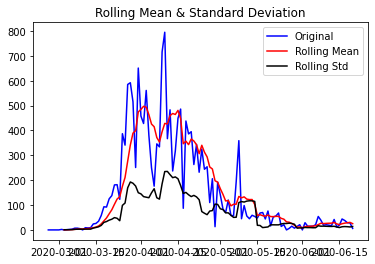

Perform Dickey-Fuller test
Test Statistic                  -1.194363
p-value                          0.676016
#Lags Used                       5.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [16]:
dickerFuller_test(df_norte)

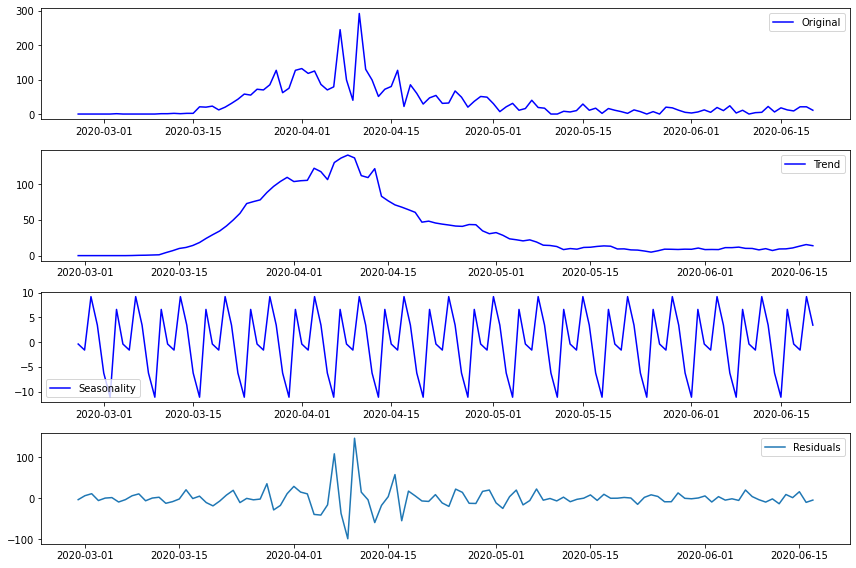

In [17]:
seasonal_centro,trend_centro=seasonal_decomposition(df_centro)

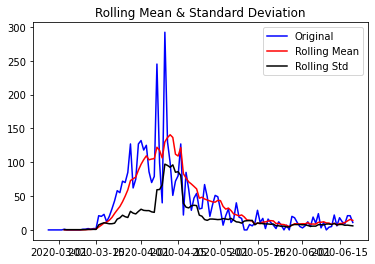

Perform Dickey-Fuller test
Test Statistic                  -1.559688
p-value                          0.503805
#Lags Used                       3.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64


In [18]:
dickerFuller_test(df_centro)

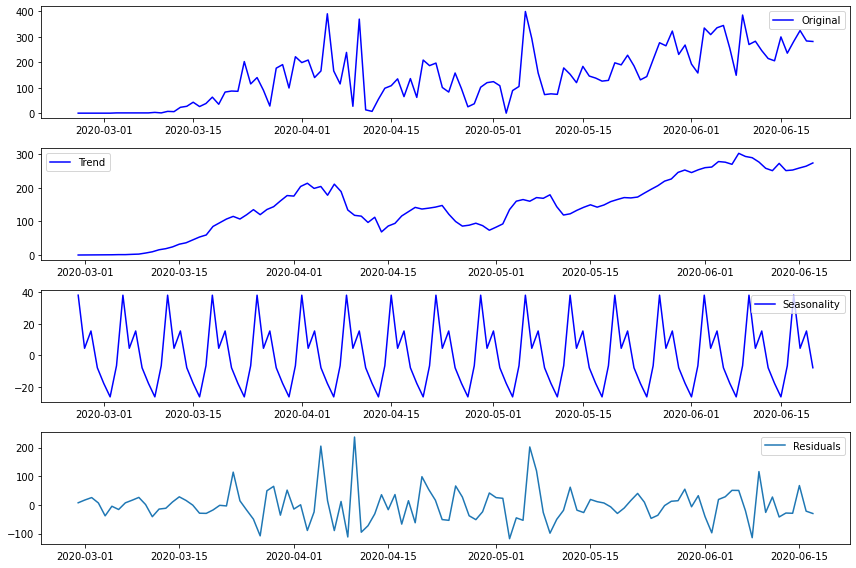

In [19]:
seasonal_lvt,trend_lvt=seasonal_decomposition(df_lvt)

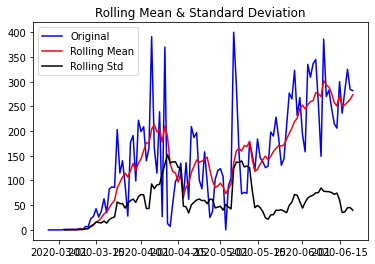

Perform Dickey-Fuller test
Test Statistic                  -1.352090
p-value                          0.605017
#Lags Used                       5.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [20]:
dickerFuller_test(df_lvt)

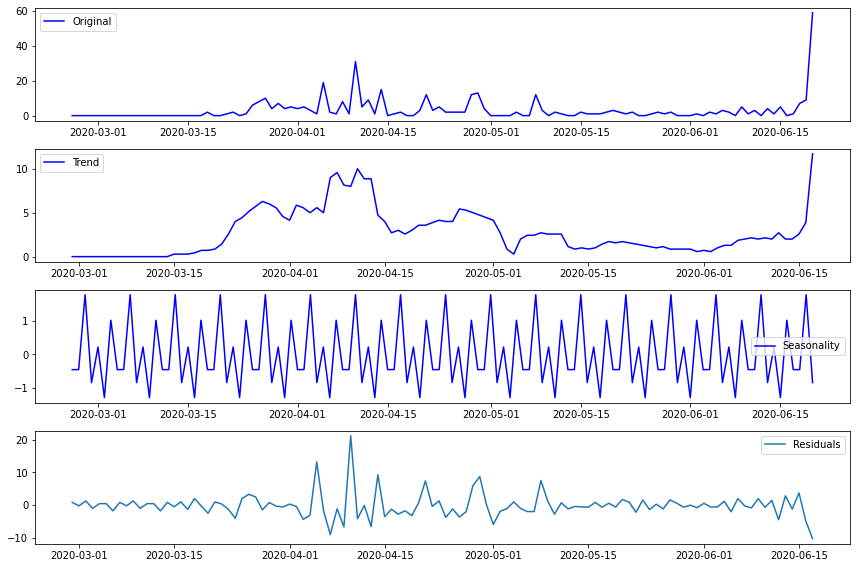

In [21]:
seasonal_alentejo,trend_alentejo=seasonal_decomposition(df_alentejo)

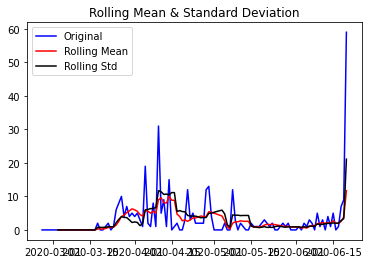

Perform Dickey-Fuller test
Test Statistic                  -2.170176
p-value                          0.217247
#Lags Used                       1.000000
Number of Observations Used    114.000000
Critical Value (1%)             -3.489058
Critical Value (5%)             -2.887246
Critical Value (10%)            -2.580481
dtype: float64


In [22]:
dickerFuller_test(df_alentejo)

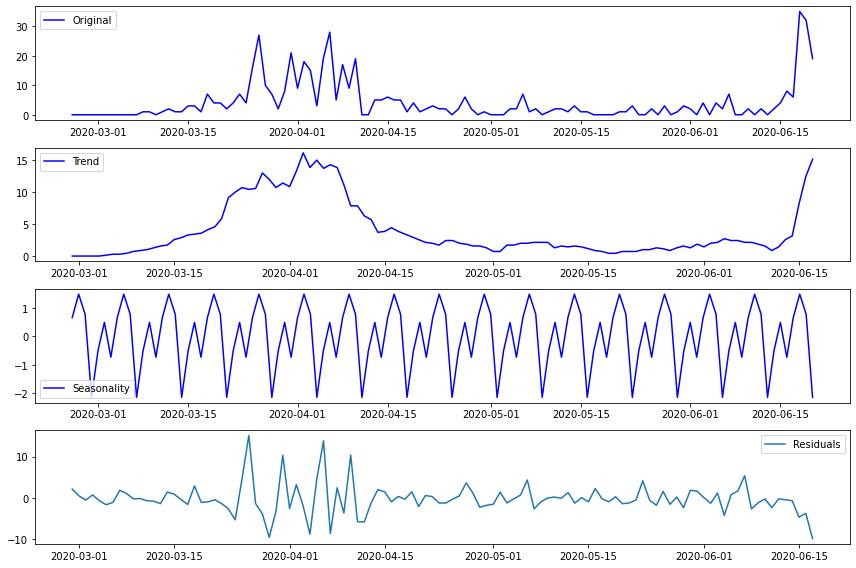

In [23]:
seasonal_algarve,trend_algarve=seasonal_decomposition(df_algarve)

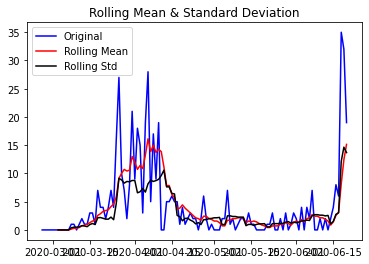

Perform Dickey-Fuller test
Test Statistic                  -1.950328
p-value                          0.308768
#Lags Used                       2.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [24]:
dickerFuller_test(df_algarve)

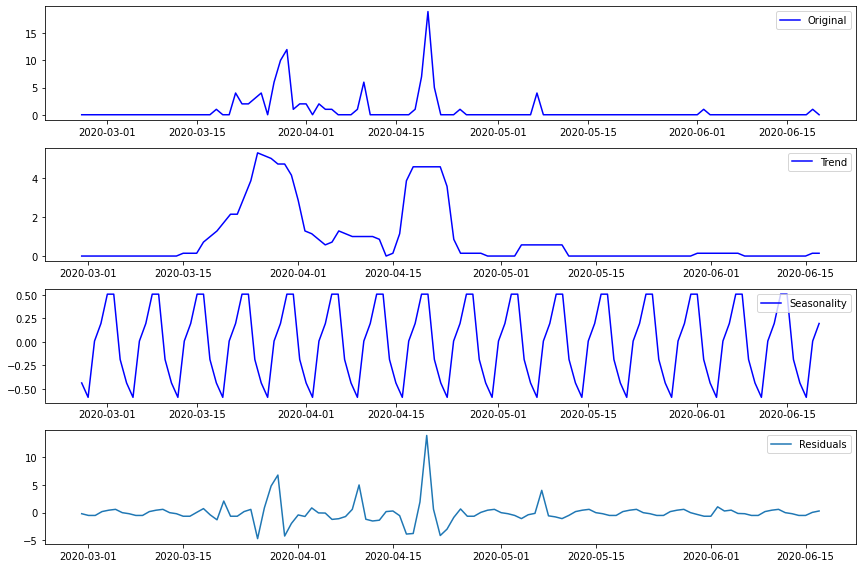

In [25]:
seasonal_madeira,trend_madeira=seasonal_decomposition(df_madeira)

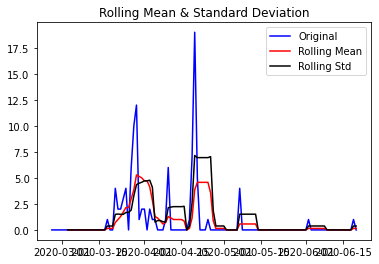

Perform Dickey-Fuller test
Test Statistic                -6.018801e+00
p-value                        1.511039e-07
#Lags Used                     0.000000e+00
Number of Observations Used    1.150000e+02
Critical Value (1%)           -3.488535e+00
Critical Value (5%)           -2.887020e+00
Critical Value (10%)          -2.580360e+00
dtype: float64


In [26]:
dickerFuller_test(df_madeira)

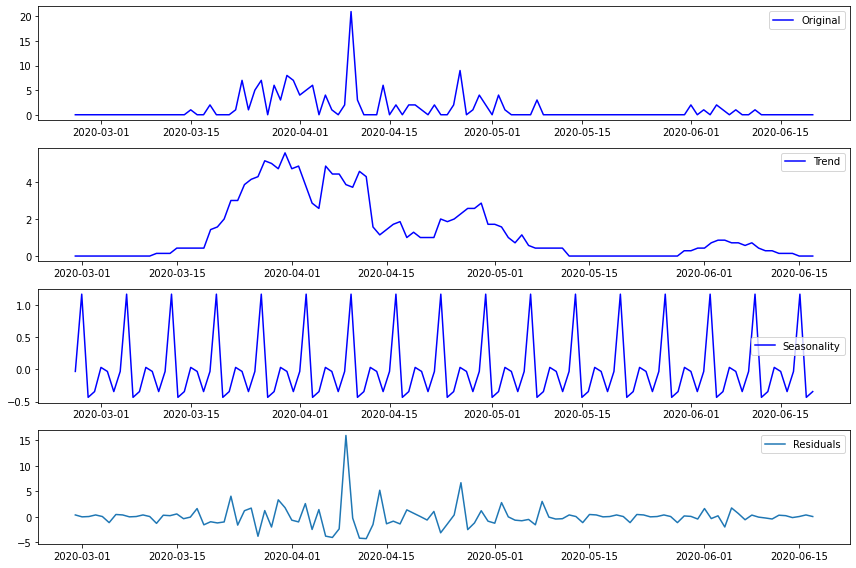

In [27]:
seasonal_acores,trend_acores=seasonal_decomposition(df_acores)

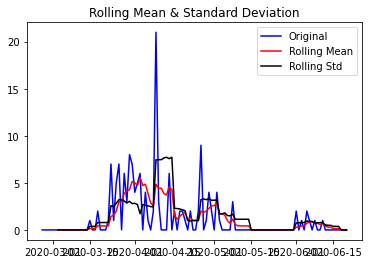

Perform Dickey-Fuller test
Test Statistic                  -2.219543
p-value                          0.199229
#Lags Used                       5.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [28]:
dickerFuller_test(df_acores)

###Conclusão
Todas as regiões apresentam sazonalidade, como é possível observar-se pelos gráficos, o que levam a concluir que são dados não estacionários. 
Para concluir que os dados são, de facto, não estacionários, procedi a fazer o teste Dickey-Fuller.

H0: Os dados são não estacionários

* p-value > 0.05: Não rejeitamos a hipótese nula (H0), isto é, os dados têm uma raiz unitárias (*unit root*) e são não estacionários.

* p-value <= 0.05: Rejeitamos a hipótese nula (H0), isto é, os dados não têm uma raiz unitárias (*unit root*) e são estacionários.

Com o teste Dickey-Fuller concluiu-se que, de facto, todos os dados são não estacionários porque todos os p-value > 0.05 o que significa que os dados têm uma estrutura dependente do periodo. Sendo que se trata de um vírus, esta conclusão vai em conta com os dados de outros vírus que têm uma dependência no tempo como, por exemplo, o vírus da gripe (Influenza) que tem o início da sua presença no mês de novembro e em que, no caso de Portugal (dados obtidos no site da DGS) apresenta maior atividade gripal entre dezembro e fevereiro.

Pelos gráficos é possível observar-se que os dados apresentam sazonalidade, o que não permite o uso do modelo ARIMA.
Dessa forma, foi implementado o modelo SARIMA.

##SARIMA

O SARIMA ou ARIMA Sazonal, é uma extensão do ARIMA que suporta explicitamente dados de séries temporais univariadas com uma componente sazonal.

Ele adiciona três novos hiperparâmetros para especificar a regressão automática (AR), a diferenciação (I) e a média móvel (MA) para o componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.

Esses elementos são quatro elementos sazonais que não fazem parte do ARIMA que devem ser configurados; eles são:

P: ordem autoregressiva sazonal.
D: Ordem da diferença sazonal.
Q: Ordem média móvel sazonal.
m: o número de etapas de tempo para um único período sazonal.

Importante, o parâmetro m influencia os parâmetros P, D e Q. Por exemplo, um m de 12 para dados mensais sugere um ciclo sazonal anual.

###Criação do modelo SARIMA



O próximo passo passou por encontrar, a partir de uma busca exaustiva (Grid Search), os valores de p, q, d, P, D, Q e m  que permitiam ao modelo obter o menor AIC (Akaike Information Criterion). Para determinar a ordem de um modelo SARIMA, um critério útil é o critério de informação de Akaike (AIC) que tenta aproximar modelos da realidade. Quanto menor o valor do AIC para uma gama de modelos investigados, melhor o modelo se adequará aos dados. 

Esta busca pelo melhor modelo foi feita para cada uma das regiões, permitindo depois comparar tendências nos resultados destes valores.

Esses valores foram depois guardados num ficheiro CSV para permanência dos dados entre regiões e posterior análise dos parâmetros dos melhores modelos de cada região.

In [30]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0,2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 15) for x in list(itertools.product(p, d, q))]

print("PDQ:", pdq)
print("Seasonal PDQ:", seasonal_pdq)

PDQ: [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
Seasonal PDQ: [(0, 0, 0, 15), (0, 0, 1, 15), (0, 0, 2, 15), (0, 1, 0, 15), (0, 1, 1, 15), (0, 1, 2, 15), (1, 0, 0, 15), (1, 0, 1, 15), (1, 0, 2, 15), (1, 1, 0, 15), (1, 1, 1, 15), (1, 1, 2, 15), (2, 0, 0, 15), (2, 0, 1, 15), (2, 0, 2, 15), (2, 1, 0, 15), (2, 1, 1, 15), (2, 1, 2, 15)]


In [395]:
best_fileSARIMA = model_folder + '/bestResult_SARIMA.csv'

In [32]:
def sarimax_bestParameters(df, pdq, seasonal_pdq, city):
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    export_file = model_folder + '/SARIMA' + city + '.csv'
    conf = list()
    best_aic = None
    for param in pdq:
        for param_seasonal in seasonal_pdq: 
            error=0
            try:
                mod = SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit(disp=False)
                print('SARIMA {} x {} - AIC: {}'.format(param, param_seasonal, results.aic))
                
                conf.append([city, param, param_seasonal, results.aic])
                if best_aic is None or results.aic < best_aic:
                    best_aic = results.aic
                    best_config = (city, param, param_seasonal, results.aic)
            except:
                continue
    best_file = list()
    best_file.append([best_config[0], best_config[1], best_config[2], best_config[3]])
    pd.DataFrame(conf).to_csv(export_file, header=["city", "p, d, q", "P, D, Q, m", "aic"]) 
    if path.exists(best_fileSARIMA):
        pd.DataFrame(best_file).to_csv(best_fileSARIMA, mode='a')   
    else:
        pd.DataFrame(best_file).to_csv(best_fileSARIMA, header=["city", "p, d, q", "P, D, Q, m","aic"]) 

In [33]:
sarimax_bestParameters(df_norte_aux, pdq, seasonal_pdq, "Norte")

SARIMA (0, 0, 0) x (0, 0, 0, 15) - AIC: 1586.581986617859
SARIMA (0, 0, 0) x (0, 0, 1, 15) - AIC: 1347.9830495092122
SARIMA (0, 0, 0) x (0, 0, 2, 15) - AIC: 3319.4045818323193
SARIMA (0, 0, 0) x (0, 1, 0, 15) - AIC: 1360.9113101255552
SARIMA (0, 0, 0) x (0, 1, 1, 15) - AIC: 1158.649471739988
SARIMA (0, 0, 0) x (0, 1, 2, 15) - AIC: 2521.470821076871
SARIMA (0, 0, 0) x (1, 0, 0, 15) - AIC: 1355.558318935937
SARIMA (0, 0, 0) x (1, 0, 1, 15) - AIC: 1340.7609791453153
SARIMA (0, 0, 0) x (1, 0, 2, 15) - AIC: 3198.8927257901078
SARIMA (0, 0, 0) x (1, 1, 0, 15) - AIC: 1178.1119814156734
SARIMA (0, 0, 0) x (1, 1, 1, 15) - AIC: 1153.0818456009015
SARIMA (0, 0, 0) x (1, 1, 2, 15) - AIC: 3076.8502246222615
SARIMA (0, 0, 0) x (2, 0, 0, 15) - AIC: 1156.8781934096817
SARIMA (0, 0, 0) x (2, 0, 1, 15) - AIC: 1121.7405095339311
SARIMA (0, 0, 0) x (2, 0, 2, 15) - AIC: 3492.582903609277
SARIMA (0, 0, 0) x (2, 1, 0, 15) - AIC: 919.0420546229346
SARIMA (0, 0, 0) x (2, 1, 1, 15) - AIC: 920.6302665530377
SARI

In [34]:
sarimax_bestParameters(df_centro_aux, pdq, seasonal_pdq, "Centro")

SARIMA (0, 0, 0) x (0, 0, 0, 15) - AIC: 1264.2937279460698
SARIMA (0, 0, 0) x (0, 0, 1, 15) - AIC: 1083.1204024477895
SARIMA (0, 0, 0) x (0, 0, 2, 15) - AIC: 3287.8911964533268
SARIMA (0, 0, 0) x (0, 1, 0, 15) - AIC: 1101.7800852883622
SARIMA (0, 0, 0) x (0, 1, 1, 15) - AIC: 935.5061971746538
SARIMA (0, 0, 0) x (0, 1, 2, 15) - AIC: 2740.5116746906915
SARIMA (0, 0, 0) x (1, 0, 0, 15) - AIC: 1088.6761945797155
SARIMA (0, 0, 0) x (1, 0, 1, 15) - AIC: 1079.1697993504015
SARIMA (0, 0, 0) x (1, 0, 2, 15) - AIC: 3275.692624668512
SARIMA (0, 0, 0) x (1, 1, 0, 15) - AIC: 956.3701516602208
SARIMA (0, 0, 0) x (1, 1, 1, 15) - AIC: 932.9081654841366
SARIMA (0, 0, 0) x (1, 1, 2, 15) - AIC: 2812.747022032463
SARIMA (0, 0, 0) x (2, 0, 0, 15) - AIC: 934.5410930372765
SARIMA (0, 0, 0) x (2, 0, 1, 15) - AIC: 899.7591602407628
SARIMA (0, 0, 0) x (2, 0, 2, 15) - AIC: 3258.3322619833325
SARIMA (0, 0, 0) x (2, 1, 0, 15) - AIC: 728.1967381076955
SARIMA (0, 0, 0) x (2, 1, 1, 15) - AIC: 714.4136926706291
SARIMA

In [35]:
sarimax_bestParameters(df_lvt_aux, pdq, seasonal_pdq, "LVT")

SARIMA (0, 0, 0) x (0, 0, 0, 15) - AIC: 1521.5596653331672
SARIMA (0, 0, 0) x (0, 0, 1, 15) - AIC: 1284.417812743327
SARIMA (0, 0, 0) x (0, 0, 2, 15) - AIC: 3441.1506782432243
SARIMA (0, 0, 0) x (0, 1, 0, 15) - AIC: 1226.0264056072792
SARIMA (0, 0, 0) x (0, 1, 1, 15) - AIC: 1045.0706795512544
SARIMA (0, 0, 0) x (0, 1, 2, 15) - AIC: 2823.502579256053
SARIMA (0, 0, 0) x (1, 0, 0, 15) - AIC: 1239.231711712957
SARIMA (0, 0, 0) x (1, 0, 1, 15) - AIC: 1207.5990056608612
SARIMA (0, 0, 0) x (1, 0, 2, 15) - AIC: 3441.2204659443387
SARIMA (0, 0, 0) x (1, 1, 0, 15) - AIC: 1058.216295496291
SARIMA (0, 0, 0) x (1, 1, 1, 15) - AIC: 1040.318759907984
SARIMA (0, 0, 0) x (1, 1, 2, 15) - AIC: 2947.198162257576
SARIMA (0, 0, 0) x (2, 0, 0, 15) - AIC: 1058.9319820652095
SARIMA (0, 0, 0) x (2, 0, 1, 15) - AIC: 1040.5895749110086
SARIMA (0, 0, 0) x (2, 0, 2, 15) - AIC: 3612.4240016798276
SARIMA (0, 0, 0) x (2, 1, 0, 15) - AIC: 849.2933289152064
SARIMA (0, 0, 0) x (2, 1, 1, 15) - AIC: 853.5988454552215
SARIM

In [36]:
sarimax_bestParameters(df_alentejo_aux, pdq, seasonal_pdq, "Alentejo")

SARIMA (0, 0, 0) x (0, 0, 0, 15) - AIC: 792.9905345908511
SARIMA (0, 0, 0) x (0, 0, 1, 15) - AIC: 701.6804039420031
SARIMA (0, 0, 0) x (0, 0, 2, 15) - AIC: 3900.197582778976
SARIMA (0, 0, 0) x (0, 1, 0, 15) - AIC: 712.6735003763526
SARIMA (0, 0, 0) x (0, 1, 1, 15) - AIC: 604.1576662148166
SARIMA (0, 0, 0) x (0, 1, 2, 15) - AIC: 2679.0304802146056
SARIMA (0, 0, 0) x (1, 0, 0, 15) - AIC: 704.8065892631532
SARIMA (0, 0, 0) x (1, 0, 1, 15) - AIC: 700.596411855661
SARIMA (0, 0, 0) x (1, 0, 2, 15) - AIC: 3114.089597285247
SARIMA (0, 0, 0) x (1, 1, 0, 15) - AIC: 619.8879976517699
SARIMA (0, 0, 0) x (1, 1, 1, 15) - AIC: 607.9731394263424
SARIMA (0, 0, 0) x (1, 1, 2, 15) - AIC: 2214.195029293922
SARIMA (0, 0, 0) x (2, 0, 0, 15) - AIC: 614.4640246799539
SARIMA (0, 0, 0) x (2, 0, 1, 15) - AIC: 613.1117474841047
SARIMA (0, 0, 0) x (2, 0, 2, 15) - AIC: 3258.229661324881
SARIMA (0, 0, 0) x (2, 1, 0, 15) - AIC: 508.9145450593797
SARIMA (0, 0, 0) x (2, 1, 1, 15) - AIC: 510.8149959460145
SARIMA (0, 0, 

In [37]:
sarimax_bestParameters(df_algarve_aux, pdq, seasonal_pdq, "Algarve")

SARIMA (0, 0, 0) x (0, 0, 0, 15) - AIC: 809.4213268686626
SARIMA (0, 0, 0) x (0, 0, 1, 15) - AIC: 708.3056381392139
SARIMA (0, 0, 0) x (0, 0, 2, 15) - AIC: 3207.649498993752
SARIMA (0, 0, 0) x (0, 1, 0, 15) - AIC: 724.4144695638466
SARIMA (0, 0, 0) x (0, 1, 1, 15) - AIC: 599.9578881279816
SARIMA (0, 0, 0) x (0, 1, 2, 15) - AIC: 2709.079736853296
SARIMA (0, 0, 0) x (1, 0, 0, 15) - AIC: 712.5818391022838
SARIMA (0, 0, 0) x (1, 0, 1, 15) - AIC: 704.5751992301346
SARIMA (0, 0, 0) x (1, 0, 2, 15) - AIC: 3327.3220297192656
SARIMA (0, 0, 0) x (1, 1, 0, 15) - AIC: 620.2745667264585
SARIMA (0, 0, 0) x (1, 1, 1, 15) - AIC: 601.9425958325392
SARIMA (0, 0, 0) x (1, 1, 2, 15) - AIC: 3070.7968284430935
SARIMA (0, 0, 0) x (2, 0, 0, 15) - AIC: 606.7600819817105
SARIMA (0, 0, 0) x (2, 0, 1, 15) - AIC: 600.4929564427597
SARIMA (0, 0, 0) x (2, 0, 2, 15) - AIC: 3151.294679185917
SARIMA (0, 0, 0) x (2, 1, 0, 15) - AIC: 492.2613435495666
SARIMA (0, 0, 0) x (2, 1, 1, 15) - AIC: 484.8677319162298
SARIMA (0, 0

In [38]:
sarima_results = read_dataset(best_fileSARIMA)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
print(sarima_results)

            p, d, q     P, D, Q, m         aic
city                                          
Norte     (2, 1, 2)  (2, 1, 0, 15)  827.299309
Centro    (2, 1, 2)  (2, 1, 1, 15)  641.741360
LVT       (2, 1, 2)  (2, 1, 1, 15)  787.134483
Alentejo  (2, 1, 0)  (2, 1, 0, 15)  488.121654
Algarve   (2, 1, 0)  (2, 1, 1, 15)  424.700799


In [30]:
norteSarima_order = (2,1,2)
norteSarima_seasonal = (2,1,0,15)

centroSarima_order = (2,1,2)
centroSarima_seasonal = (2,1,1,15)

lvtSarima_order = (2,1,2)
lvtSarima_seasonal = (2,1,1,15)

alentejoSarima_order = (2,1,0)
alentejoSarima_seasonal = (2,1,0,15)

algarveSarima_order = (2,1,0)
algarveSarima_seasonal = (2,1,1,15)

In [88]:
def create_optim_SARIMA(df, order_param, seasonal_param):
  mod = SARIMAX(df,order=order_param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False)

  results = mod.fit(disp=False)
  #imprimir coeficientes
  print(results.summary().tables[1])

  results.plot_diagnostics(figsize=(15,15))
  plt.show()

  return results

O sumário do modelo após o treino indica-nos os coeficientes da função usada pelo modelo SARIMAX.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7129      0.192     -3.706      0.000      -1.090      -0.336
ar.L2          0.2590      0.188      1.375      0.169      -0.110       0.628
ma.L1          0.2126      0.307      0.691      0.489      -0.390       0.815
ma.L2         -0.7875      0.209     -3.772      0.000      -1.197      -0.378
ar.S.L15      -0.3956      0.103     -3.823      0.000      -0.598      -0.193
ar.S.L30      -0.3330      0.102     -3.271      0.001      -0.533      -0.134
sigma2      1.074e+04   3.65e-05   2.94e+08      0.000    1.07e+04    1.07e+04


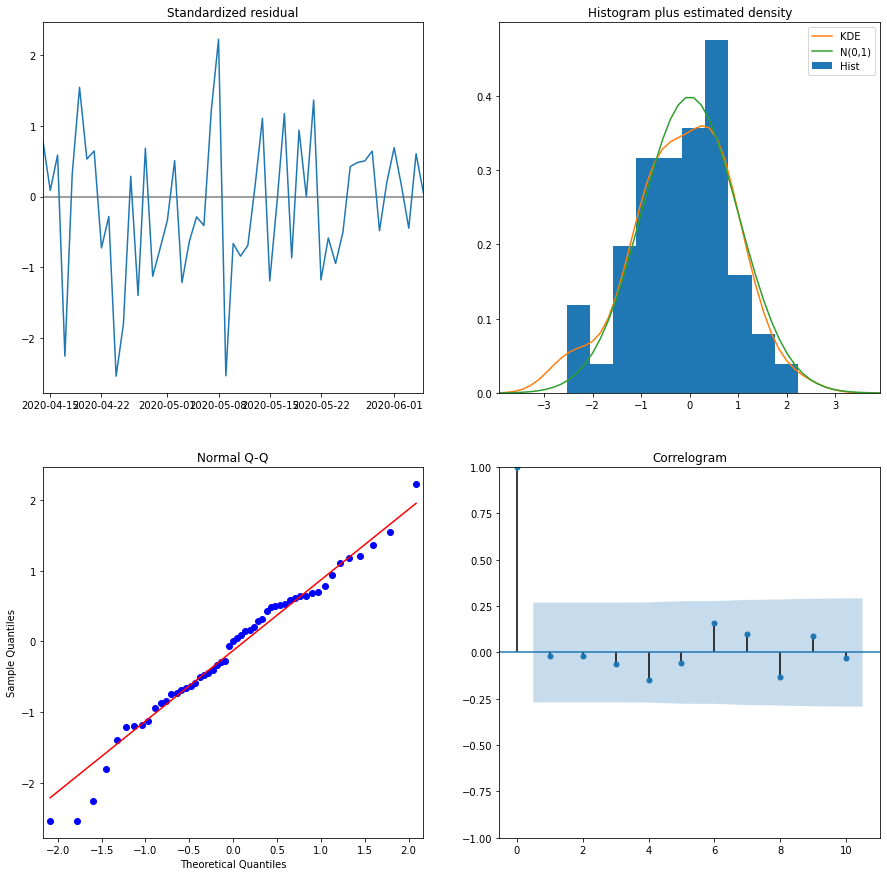

In [146]:
sarimaNorte = create_optim_SARIMA(df_norte_aux_train, norteSarima_order, norteSarima_seasonal)

> Norte

* Standardized Residuals: os residuos não mostram uma óbvia sazonalidade e aparentam ser ruído.

* Histogram plus estimated density plot: a linha vermelha KDE segue proximamente a linha N(0, 1) (normal). É uma boa indicação de que os residuos estão normalizados com média igual a 0 e desvio padrão igual a 1. 

* The Q-Q-plot: mostra que a ordenada distribuição dos resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1). Isso é uma indicação de que os resíduos são normalmente distribuídos.

* The Correlogram plot: mostra que os resíduos dos dados têm baixa correlação com versões atrasadas de si mesmas.

Podemos concluir, então, que é um bom modelo para fazer previsões.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9176      0.233     -3.943      0.000      -1.374      -0.461
ar.L2         -0.0200      0.201     -0.100      0.921      -0.414       0.374
ma.L1          0.3173    498.701      0.001      0.999    -977.119     977.753
ma.L2         -0.6827    340.465     -0.002      0.998    -667.981     666.616
ar.S.L15      -0.6863      0.066    -10.393      0.000      -0.816      -0.557
ar.S.L30      -0.3307      0.066     -5.020      0.000      -0.460      -0.202
ma.S.L15       0.9998   1017.558      0.001      0.999   -1993.377    1995.376
sigma2       508.9726   5.94e+05      0.001      0.999   -1.16e+06    1.16e+06


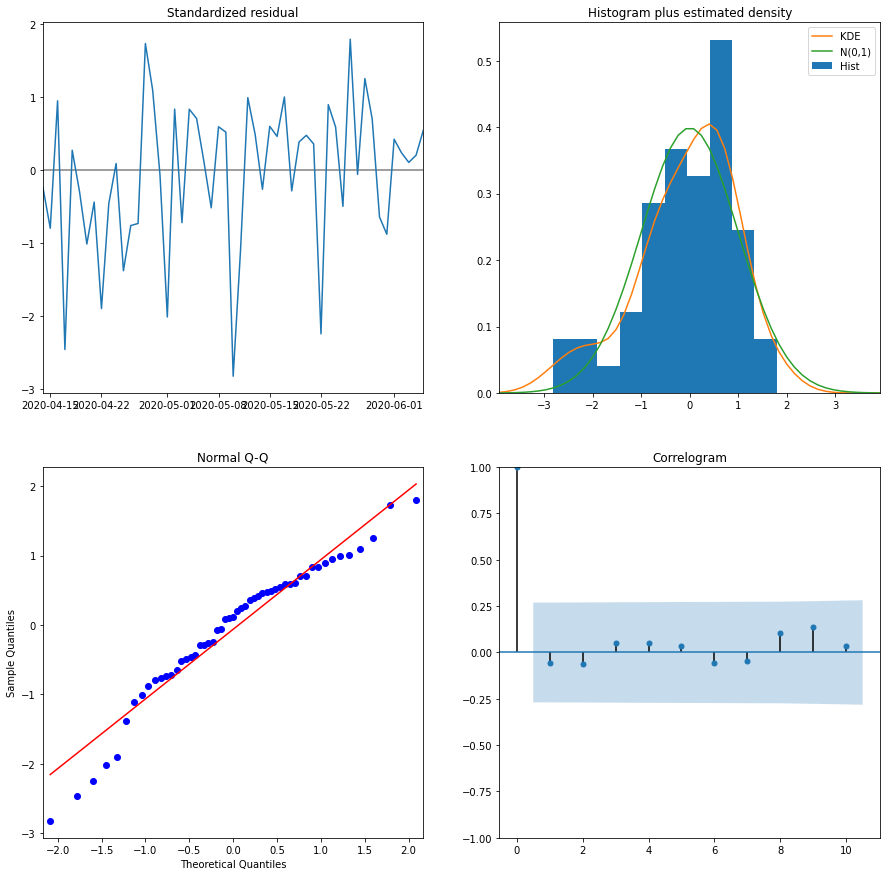

In [228]:
sarimaCentro = create_optim_SARIMA(df_centro_aux_train, centroSarima_order, centroSarima_seasonal)

> Centro

* Standardized Residuals: os residuos não mostram uma óbvia sazonalidade e aparentam ser ruído.

* Histogram plus estimated density plot: a linha vermelha KDE tem um pequeno desfasamento em relação à linha N(0, 1) (normal). No entanto, é possível afirmar que os residuos aparentam estar normalizados com média igual a 0 e desvio padrão igual a 1.

* The Q-Q-plot: confirma a conclusão tirada no ponto anterior pois a ordenada distribuição dos resíduos (pontos azuis) aparentam cair sobre a linha representativa da tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1). 

* The Correlogram plot: mostra que os resíduos dos dados têm baixa correlação com versões atrasadas de si mesmas.

Podemos concluir, então, que é um bom modelo para fazer previsões, no entanto não será o mais representativo do problema.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7616      0.210     -3.626      0.000      -1.173      -0.350
ar.L2          0.2207      0.215      1.028      0.304      -0.200       0.641
ma.L1          0.1450      0.205      0.707      0.479      -0.257       0.547
ma.L2         -0.8550      0.234     -3.652      0.000      -1.314      -0.396
ar.S.L15      -0.5013      0.188     -2.670      0.008      -0.869      -0.133
ar.S.L30      -0.4055      0.107     -3.778      0.000      -0.616      -0.195
ma.S.L15       0.0989      0.282      0.351      0.726      -0.454       0.652
sigma2      5068.8508   6.73e-05   7.54e+07      0.000    5068.851    5068.851


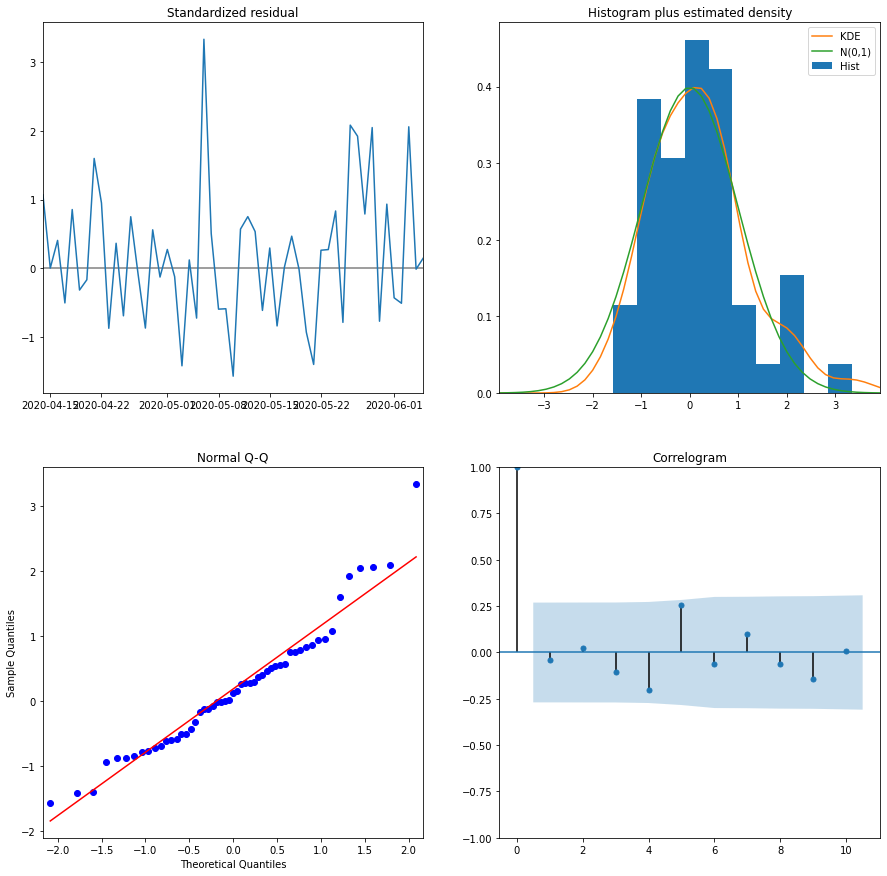

In [227]:
sarimaLvt = create_optim_SARIMA(df_lvt_aux_train, lvtSarima_order, lvtSarima_seasonal)

> Lisboa e Vale do Tejo

* Standardized Residuals: os residuos não mostram uma óbvia sazonalidade e aparentam ser ruído.

* Histogram plus estimated density plot: a linha vermelha KDE segue quase que perfeitamente a linha N(0, 1) (normal). Podemos concluir que os resíduos estão normalizados com média igual a 0 e desvio padrão igual a 1. 

* The Q-Q-plot: mostra que a ordenada distribuição dos resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1). Isso é uma indicação de que os resíduos são normalmente distribuídos.

* The Correlogram plot: mostra que os resíduos dos dados têm baixa correlação com versões atrasadas de si mesmas.

Podemos concluir, então, que é um bom modelo para fazer previsões.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5109      0.165     -3.096      0.002      -0.834      -0.187
ar.L2         -0.1883      0.213     -0.884      0.377      -0.606       0.229
ar.S.L15      -0.6785      0.067    -10.084      0.000      -0.810      -0.547
ar.S.L30      -0.3804      0.088     -4.322      0.000      -0.553      -0.208
sigma2        30.0650      5.498      5.468      0.000      19.288      40.842


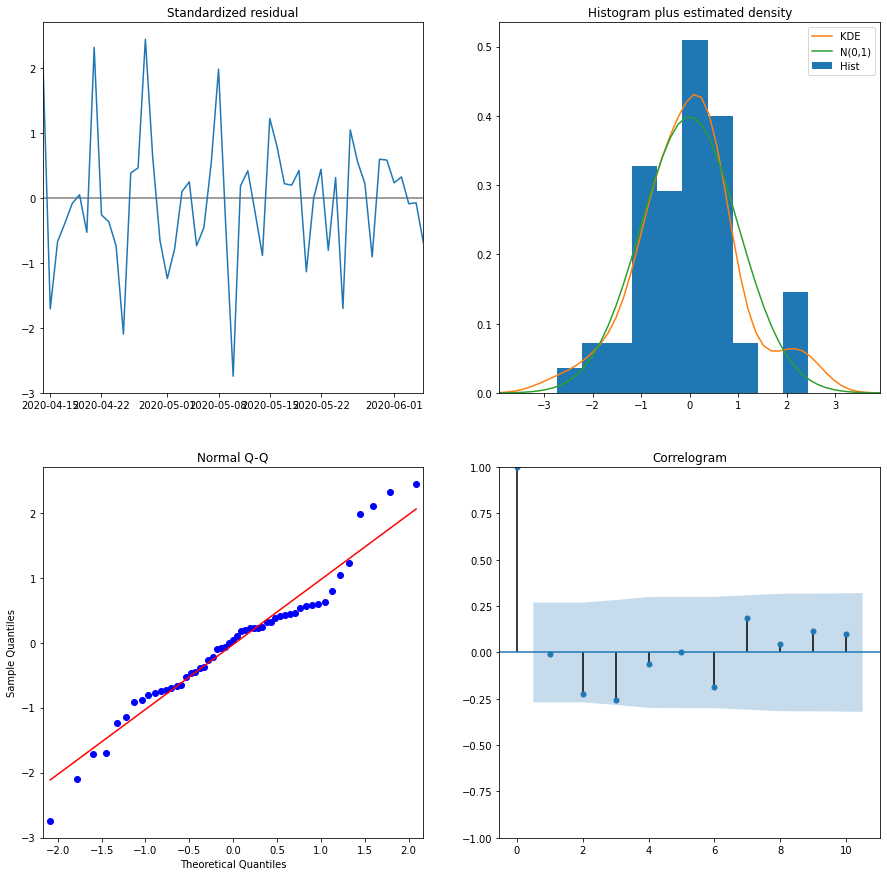

In [226]:
sarimaAlentejo = create_optim_SARIMA(df_alentejo_aux_train, alentejoSarima_order, alentejoSarima_seasonal)

> Alentejo

* Standardized Residuals: os residuos não mostram uma óbvia sazonalidade e aparentam ser ruído.

* Histogram plus estimated density plot: a linha vermelha KDE segue proximamente a linha N(0, 1) (normal). É uma boa indicação de que os residuos estão normalizados com média igual a 0 e desvio padrão igual a 1. 

* The Q-Q-plot: mostra que a ordenada distribuição dos resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1). Isso é uma indicação de que os resíduos são normalmente distribuídos.

* The Correlogram plot: mostra que os resíduos dos dados têm baixa correlação com versões atrasadas de si mesmas.

Podemos concluir, então, que é um bom modelo para fazer previsões.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3518      0.109     -3.214      0.001      -0.566      -0.137
ar.L2         -0.2723      0.144     -1.893      0.058      -0.554       0.010
ar.S.L15      -0.7954      0.058    -13.832      0.000      -0.908      -0.683
ar.S.L30      -0.3163      0.058     -5.496      0.000      -0.429      -0.203
ma.S.L15       0.9999   1400.075      0.001      0.999   -2743.096    2745.096
sigma2         8.5073   1.19e+04      0.001      0.999   -2.33e+04    2.34e+04


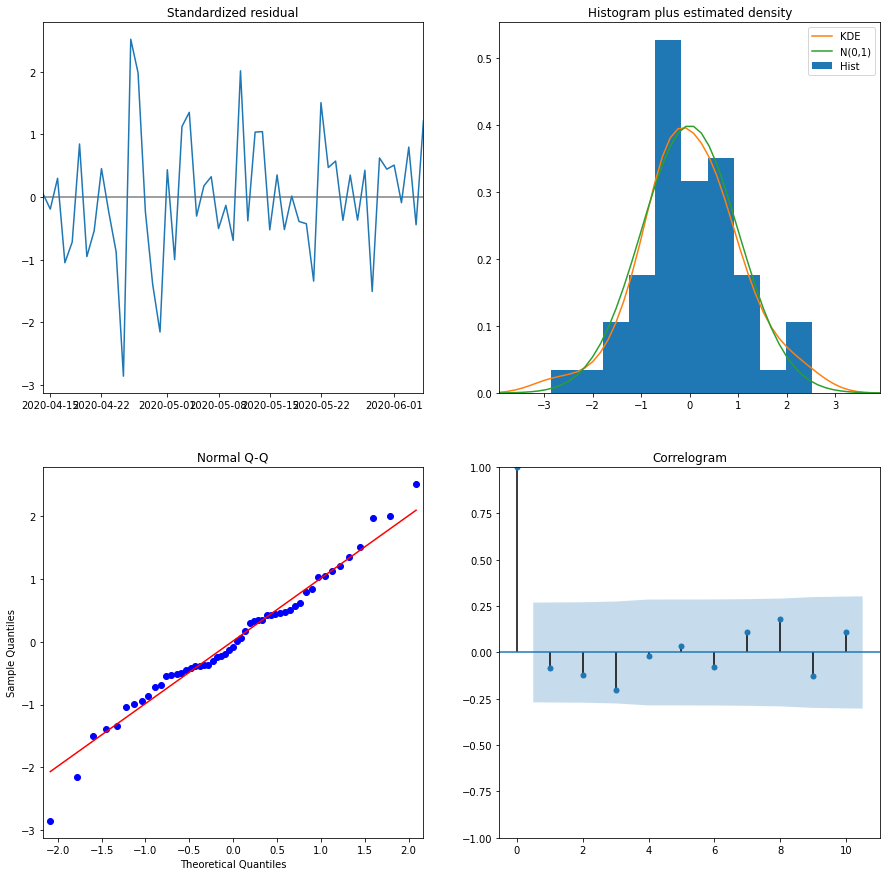

In [225]:
sarimaAlgarve = create_optim_SARIMA(df_algarve_aux_train, algarveSarima_order, algarveSarima_seasonal)

> Algarve

* Standardized Residuals: os residuos não mostram uma óbvia sazonalidade e aparentam ser ruído.

* Histogram plus estimated density plot: a linha vermelha KDE segue quase que perfeitamente a linha N(0, 1) (normal). Os residuos estão normalizados com média igual a 0 e desvio padrão igual a 1. 

* The Q-Q-plot: mostra que a ordenada distribuição dos resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1).

* The Correlogram plot: mostra que os resíduos dos dados têm baixa correlação com versões atrasadas de si mesmas.

Podemos concluir, então, que é um bom modelo para fazer previsões.

###Gráficos para análise

Os modelos selecionados agora podem ser usados para fazer previsões de séries temporais. Devido à importância fundamental
precisão da previsão, um teste deve ser realizado para verificar a precisão da previsão, comparando as
valores de previsão com valores observacionais. Este teste também pode ajudar a perceber se existe overfitting ou underfitting. Os testes estatísticos dos resultados da previsão são analisados em detalhe nesta secção.

A previsão será feita com o modo dinâmico, isto é, os valores previstos substituem os valores reais, o que impede overfitting dos dados.

In [276]:
def predict_SARIMA(df_model, prediction_start):
  predictions = df_model.get_prediction(dynamic=prediction_start)
  predictions_conf = predictions.conf_int()
  return predictions, predictions_conf

In [280]:
def plot_pred_SARIMA(df, df_pre):
  fig, ax = plt.subplots(figsize=(9,4))
  npre = 4
  ax.set(title='Novos casos COVID', xlabel='Date', ylabel='Novos casos')

  # Plot data points
  df.plot(ax=ax, style='o', label='Observed')

  # Plot predictions
  df_pre.predicted_mean.plot(ax=ax, style='g', label='Dynamic forecast')

  legend = ax.legend(loc='lower right')

In [345]:
def plot_pred_mse_SARIMA(df, df_conf, df_pre):
  fig, ax = plt.subplots(figsize=(9,4))
  npre = 4
  ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

  # Dynamic predictions and 95% confidence intervals
  predict_dy_error = df_pre.predicted_mean - df
  predict_dy_error.plot(ax=ax, style='r', label='Dynamic forecast')
  ci = df_conf.copy()
  ci.iloc[:,0] -= df
  ci.iloc[:,1] -= df
  ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

  legend = ax.legend(loc='lower left');
  legend.get_frame().set_facecolor('w')

In [521]:
def forecast_Sarima(df, model, forecast_NumberDays):
  forecast = model.get_forecast(steps=forecast_NumberDays)
  forecast_ci = forecast.conf_int()

  #Plot

  df_prediction = np.append(df, forecast.predicted_mean)

  plt.figure(figsize=(20,20))
  plt.plot(range(len(df_prediction)), df_prediction, color='red', label='Forecast')
  plt.plot(df, color='green', label='Confirmed')
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

In [358]:
norte_data = df_norte_aux_train[df_norte_aux_train.columns[0]].values
centro_data = df_centro_aux_train[df_centro_aux_train.columns[0]].values
lvt_data = df_lvt_aux_train[df_lvt_aux_train.columns[0]].values
alentejo_data = df_alentejo_aux_train[df_alentejo_aux_train.columns[0]].values
algarve_data = df_algarve_aux_train[df_algarve_aux_train.columns[0]].values

In [261]:
pred_time = str(df_norte_aux_test.index[0])

In [242]:
pred_time

'2020-02-26 00:00:00'

In [262]:
pred_date = dt.strptime(pred_time, '%Y-%m-%d %H:%M:%S')
d = date(year=pred_date.year, month=pred_date.month, day=pred_date.day)
pred_date = d.strftime("%Y-%m-%d")

In [416]:
sarimaNorte_pre.predicted_mean.values[40]

353.21236917382197

In [417]:
norte_data[0]

0

In [441]:
def print_mse_SARIMA(df, df_prev):
  MSE = list()
  for i in range(len(norte_data)):
    MSE.append(np.square(np.subtract(df[i],df_prev.predicted_mean.values[i])).mean())
    # print("Day ", i, "\tMSE:", np.square(np.subtract(df[i],df_prev.predicted_mean.values[i])).mean())
  pos_MSE = np.where(MSE == np.amax(MSE))
  maxElement = np.amax(MSE)
  return pos_MSE, maxElement

MSE: 15452.726433341153
O dia com pior MSE foi: 45 com MSE 306991.22581527726


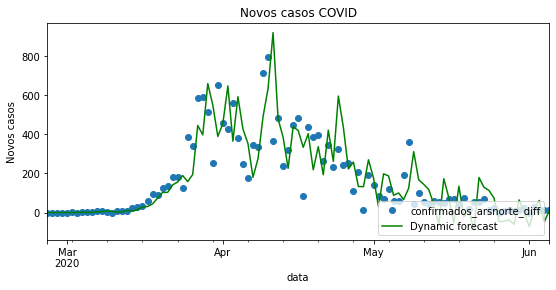

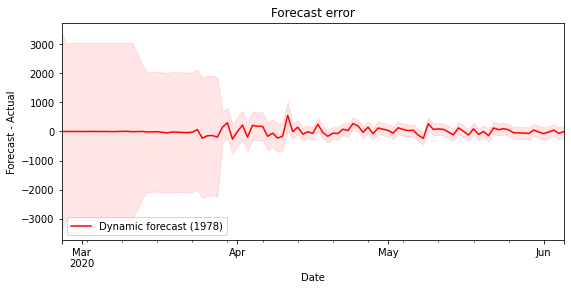

In [522]:
sarimaNorte_pre, sarimaNorte_conf = predict_SARIMA(sarimaNorte, pred_date)
plot_pred_SARIMA(df_norte_aux_train, sarimaNorte_pre)
plot_pred_mse_SARIMA(norte_data, sarimaNorte_conf, sarimaNorte_pre)
print("MSE:", mean_squared_error(norte_data, sarimaNorte_pre.predicted_mean))
mse_nortePos, mse_norte = print_mse_SARIMA(norte_data, sarimaNorte_pre)
print("O dia com pior MSE foi:", mse_nortePos[0][0], "com MSE", mse_norte)

MSE: 1739.0173385031435
O dia com pior MSE foi: 44 com MSE 51240.49352081821


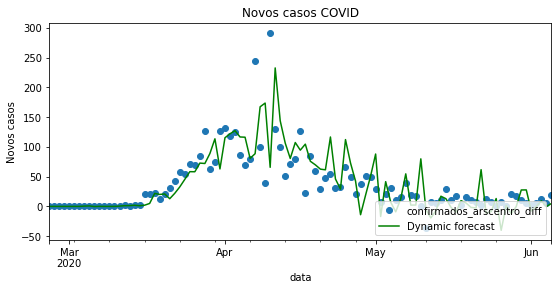

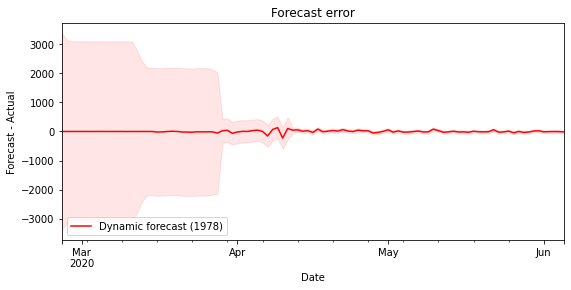

In [523]:
sarimaCentro_pre, sarimaCentro_conf = predict_SARIMA(sarimaCentro, pred_date)
plot_pred_SARIMA(df_centro_aux_train, sarimaCentro_pre)
plot_pred_mse_SARIMA(centro_data, sarimaCentro_conf, sarimaCentro_pre)
print("MSE:", mean_squared_error(centro_data, sarimaCentro_pre.predicted_mean))
mse_centroPos, mse_centro = print_mse_SARIMA(centro_data, sarimaCentro_pre)
print("O dia com pior MSE foi:", mse_centroPos[0][0], "com MSE", mse_centro)

MSE: 6859.9498106166275
O dia com pior MSE foi: 44 com MSE 74449.44116920073


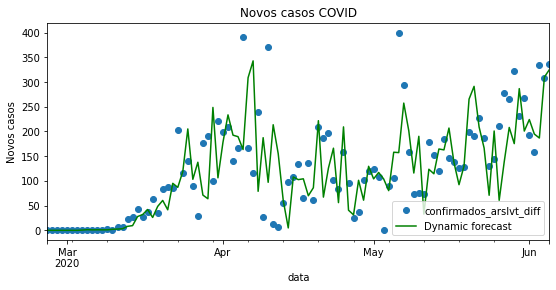

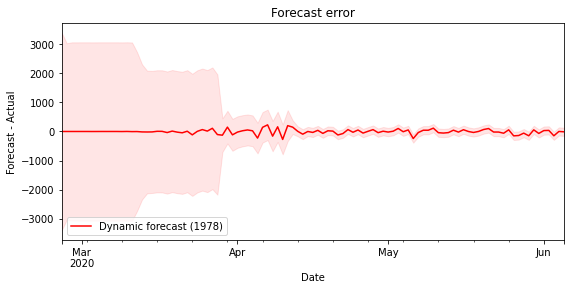

In [524]:
sarimaLvt_pre, sarimaLvt_conf = predict_SARIMA(sarimaLvt, pred_date)
plot_pred_SARIMA(df_lvt_aux_train, sarimaLvt_pre)
plot_pred_mse_SARIMA(lvt_data, sarimaLvt_conf, sarimaLvt_pre)
print("MSE:", mean_squared_error(lvt_data, sarimaLvt_pre.predicted_mean))
mse_lvtPos, mse_lvt = print_mse_SARIMA(lvt_data, sarimaLvt_pre)
print("O dia com pior MSE foi:", mse_lvtPos[0][0], "com MSE", mse_lvt)

MSE: 34.63815931459767
O dia com pior MSE foi: 44 com MSE 724.7502236450191


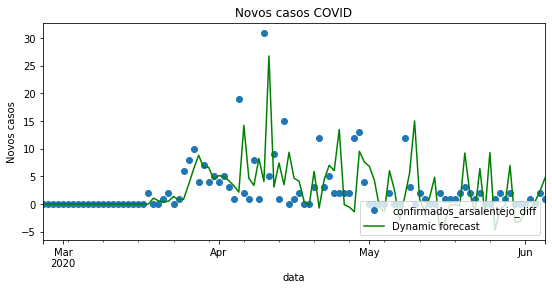

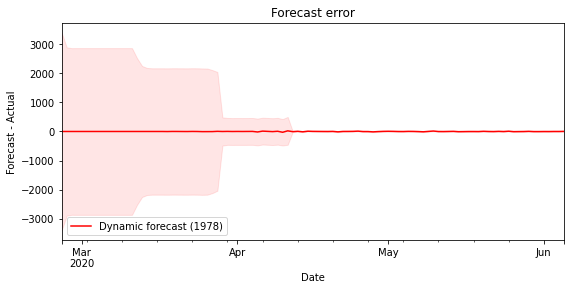

In [525]:
sarimaAlentejo_pre, sarimaAlentejo_conf = predict_SARIMA(sarimaAlentejo, pred_date)
plot_pred_SARIMA(df_alentejo_aux_train, sarimaAlentejo_pre)
plot_pred_mse_SARIMA(alentejo_data, sarimaAlentejo_conf, sarimaAlentejo_pre)
print("MSE:", mean_squared_error(alentejo_data, sarimaAlentejo_pre.predicted_mean))
mse_alentejoPos, mse_alentejo = print_mse_SARIMA(alentejo_data, sarimaAlentejo_pre)
print("O dia com pior MSE foi:", mse_alentejoPos[0][0], "com MSE", mse_alentejo)


MSE: 28.544368730546605
O dia com pior MSE foi: 41 com MSE 394.43870173077636


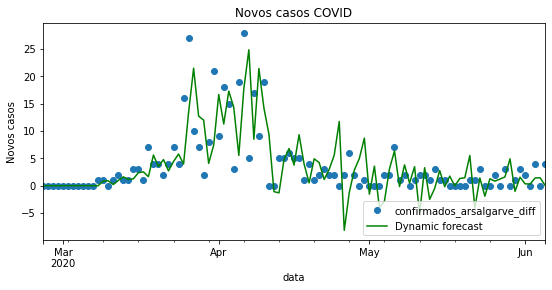

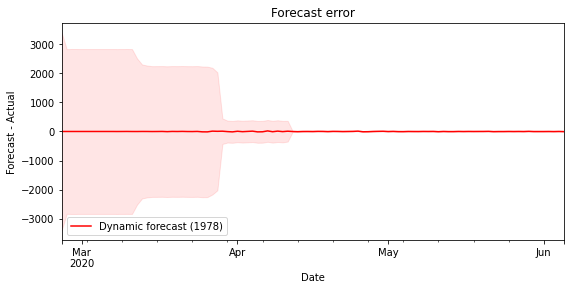

In [526]:
sarimaAlgarve_pre, sarimaAlgarve_conf = predict_SARIMA(sarimaAlgarve, pred_date)
plot_pred_SARIMA(df_algarve_aux_train, sarimaAlgarve_pre)
plot_pred_mse_SARIMA(algarve_data, sarimaAlgarve_conf, sarimaAlgarve_pre)
print("MSE:", mean_squared_error(algarve_data, sarimaAlgarve_pre.predicted_mean))
mse_algarvePos, mse_algarve = print_mse_SARIMA(algarve_data, sarimaAlgarve_pre)
print("O dia com pior MSE foi:", mse_algarvePos[0][0], "com MSE", mse_algarve)

###Conclusões

* Nos gráficos acima é possível observar-se os gráficos com as previsões para todos os dados relativos a cada região e outro gráfico com as previsões e o intervalo de confiança.
* No inicio da previsão, como o modelo utiliza os dados reais, em termos de previsão tem um grande intervalo de confiança em que os dados poderiam ficar.
* Em termos de previsões, é possível observar-se que os gráficos tendem a seguir as variações nas subidas e descidas do número de casos. No entanto, não conseguem chegar, na maioria das vezes, perto dos valores reais.

###Previsões

Agora que já foi feita a construção e análise dos modelos, será feita a previsão para um dia ainda não observado.
Nesta secção pode ser encontrados os gráficos de previsões de casos futuros (4 dias). São também mostrados os resultados passados do COVID-19.

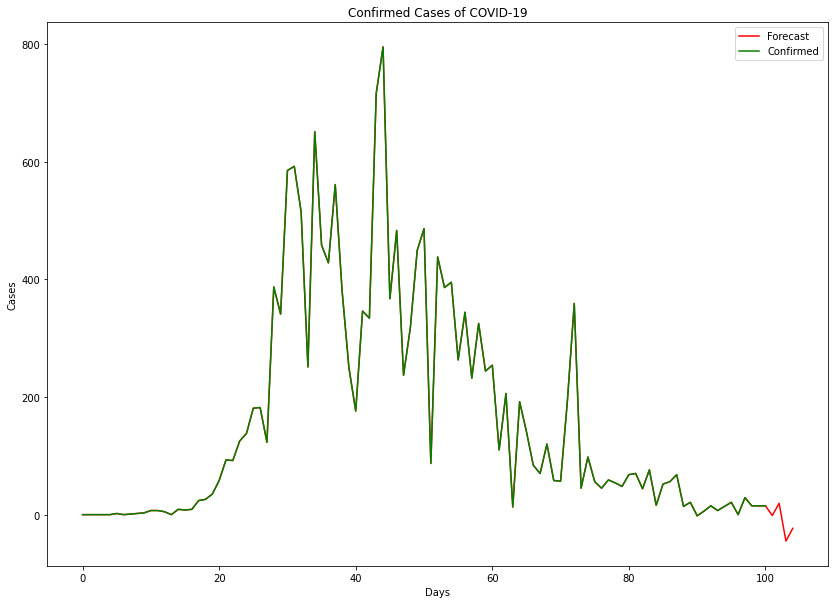

In [379]:
forecast_Sarima(norte_data, sarimaNorte, 4)

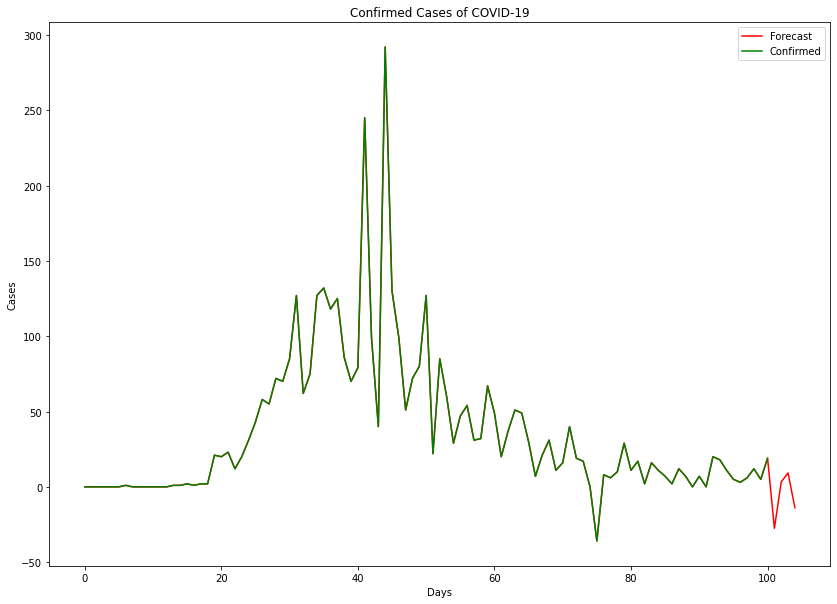

In [380]:
forecast_Sarima(centro_data, sarimaCentro, 4)

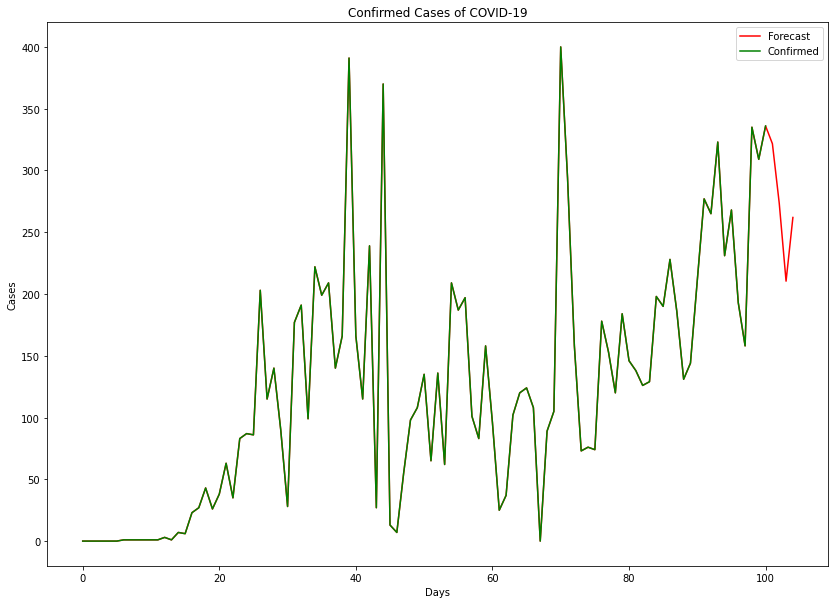

In [381]:
forecast_Sarima(lvt_data, sarimaLvt, 4)

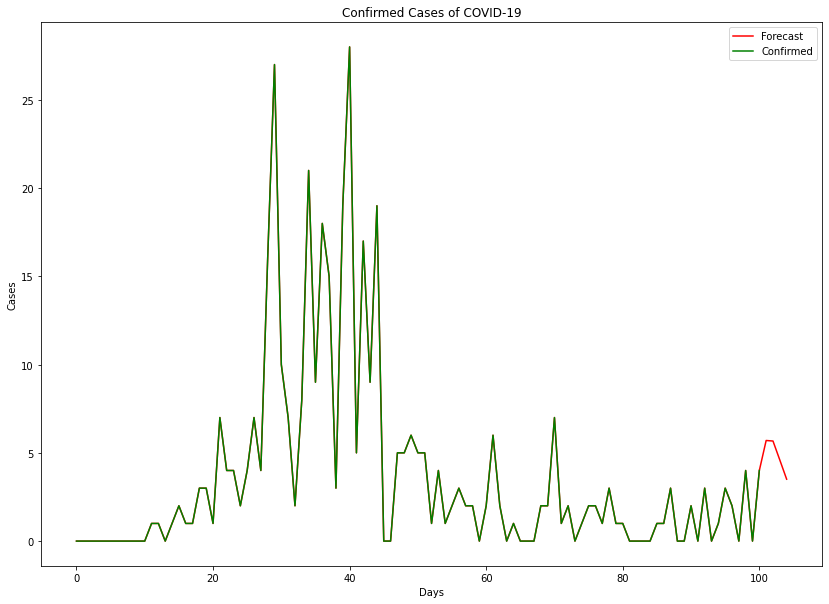

In [382]:
forecast_Sarima(algarve_data, sarimaAlgarve, 4)

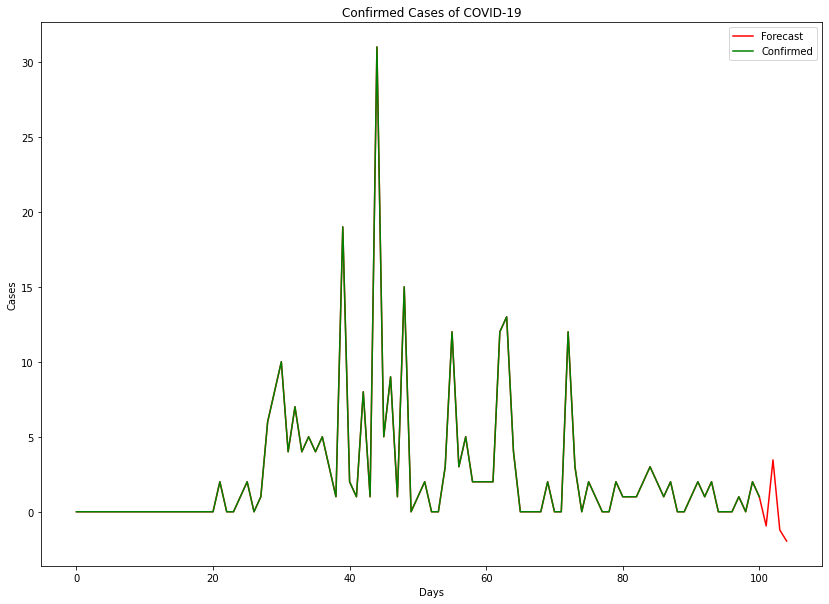

In [383]:
forecast_Sarima(alentejo_data, sarimaAlentejo, 4)

## **SVR**

Support Vector Regression (SVR) é baseado nos elementos do Support Vector Machine (SVM), em que os vetores de suporte são basicamente pontos mais próximos do hiperplano gerado em um espaço de recurso n-dimensional que distingue os pontos de dados sobre o hiperplano.
Em vários estudos já foram relatados que SVR superam a consistência na previsibilidade em relação a outros modelos de regressão linear, polinomial e logística. Por esse motivo decidi implementar um SVR para cada uma das regiões.

Por se tratar de um problema de séries temporais com poucos dados, em que a ordem dos dados é bastante importante para o treino e previsão dos novos dados, procedi a uma divisão em dados de treino e de teste a partir da função TimeSeriesSplit que permite uma nested cross-validation.
Para encontrar o melhor modelo SVR fiz uma grid search para vários valores de kernel, cache, epsilon, C e gamma, sendo os parâmetros que constituem um SVM.


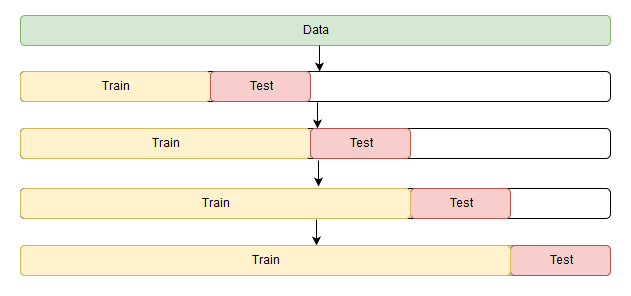

In [455]:
def save_SVRGridSearch(export_file, best_file, gs_clf, city):
	with open(export_file, 'w') as outfile:
		csvwriter = csv.writer(outfile, delimiter=',')
		#Create the header using the parameter names 
		
		header = ["mean","std"]
		param_names = [param for param in gs_clf.param_distributions.keys()]
		header.extend(param_names)
		csvwriter.writerow(header)
	
		means = gs_clf.cv_results_['mean_test_score']
		stds = gs_clf.cv_results_['std_test_score']
		params = gs_clf.cv_results_['params']

		for mean, stdev, param in zip(means, stds, params):
			row = [mean,stdev]
			# Get the list of parameter settings and add to row
			params = [str(p) for p in param.values()]
			row.extend(params)
			
			csvwriter.writerow(row)
	 
	write_header=1 
	if path.exists(best_file):
		write_header = 0

	with open(best_file, 'a') as bestfile:
		csvwriter = csv.writer(bestfile, delimiter=',')	
		if write_header == 0:
			pass
		else:
			header = ["city","score"]
			param_names = [param for param in gs_clf.param_distributions.keys()]
			header.extend(param_names)
			csvwriter.writerow(header)
	
		mean = gs_clf.best_score_
		params = gs_clf.best_params_

		row = [city, mean]
		# Get the list of parameter settings and add to row
		params = [str(p) for p in params.values()]
		row.extend(params)
		
		csvwriter.writerow(row)

In [508]:
def SVR_model(X_train, y_train, X_test, y_test, scaler, city):
  export_file = model_folder + '/svr' + city + '.csv'

  tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)

  param_search = {'kernel':('linear', 'rbf'), 
                'cache_size': [100,200,300, 20, 30, 50],
                'epsilon': [0.1, 0.01, 0.001, 0.002, 0.0001],
                "C": np.linspace(10**(-2),10**3,10),
                'gamma': np.linspace(0.0001,1,10)}

  model = svm.SVR()
  opt_model_d = RandomizedSearchCV(estimator=model, cv=tscv, param_distributions=param_search, n_jobs=1, error_score=0.0, scoring = "neg_mean_squared_error", n_iter=20)
  opt_model_d.fit(X_train, y_train)

  #Resumo dos resultados
  print("Best: %f using %s" % (opt_model_d.best_score_, opt_model_d.best_params_))

  #Guardar os resultados
  save_SVRGridSearch(export_file, best_fileSVR, opt_model_d, city)

  #Previsão
  prediction = opt_model_d.predict(X_test)
  print("Prediction:", prediction)
  scaled_prediction = prediction.reshape(1, -1)
  scaled_prediction = scaler.inverse_transform(scaled_prediction)
  scaled_realValue = y_test.reshape(1, -1)
  scaled_realValue = scaler.inverse_transform(scaled_realValue)
  for p, r in zip(scaled_prediction, scaled_realValue):
    for i in range(len(p)):
      print("Prediction:", int(p[i]), "\tReal Value:", int(r[i]))
  score_test = mean_squared_error(y_test, prediction)
  print("Test Score:", score_test)

In [515]:
SVR_model(X_train_val_norte_re, y_train_val_norte_re, X_test_norte_re, y_test_norte_re, scaler_norte, "Norte")

Best: -0.034886 using {'kernel': 'linear', 'gamma': 0.0001, 'epsilon': 0.002, 'cache_size': 100, 'C': 555.56}
Prediction: [0.04093315 0.03636287 0.03149921 0.02878201 0.04512496 0.03094319
 0.03149444 0.04710089 0.04918134 0.04579053 0.04312742]
Prediction: 30 	Real Value: 21
Prediction: 26 	Real Value: 19
Prediction: 23 	Real Value: 17
Prediction: 20 	Real Value: 42
Prediction: 33 	Real Value: 12
Prediction: 22 	Real Value: 19
Prediction: 23 	Real Value: 44
Prediction: 35 	Real Value: 38
Prediction: 37 	Real Value: 29
Prediction: 34 	Real Value: 27
Prediction: 32 	Real Value: 5
Test Score: 0.00034071932754754347


In [516]:
SVR_model(X_train_val_centro_re, y_train_val_centro_re, X_test_centro_re, y_test_centro_re, scaler_centro, "Centro")

Best: -0.022074 using {'kernel': 'linear', 'gamma': 0.11120000000000001, 'epsilon': 0.002, 'cache_size': 300, 'C': 555.56}
Prediction: [0.14873379 0.12973355 0.12787166 0.12268782 0.1348748  0.13408727
 0.15133724 0.1433641  0.14449978 0.14969432 0.15038754]
Prediction: 12 	Real Value: 0
Prediction: 6 	Real Value: 4
Prediction: 5 	Real Value: 5
Prediction: 4 	Real Value: 21
Prediction: 8 	Real Value: 5
Prediction: 7 	Real Value: 18
Prediction: 13 	Real Value: 11
Prediction: 11 	Real Value: 9
Prediction: 11 	Real Value: 21
Prediction: 13 	Real Value: 21
Prediction: 13 	Real Value: 10
Test Score: 0.0006409026031670624


In [517]:
SVR_model(X_train_val_lvt_re, y_train_val_lvt_re, X_test_lvt_re, y_test_lvt_re, scaler_lvt, "LVT")

Best: -0.070309 using {'kernel': 'linear', 'gamma': 0.4445, 'epsilon': 0.1, 'cache_size': 100, 'C': 888.89}
Prediction: [0.71709416 0.55130785 0.62574437 0.56681529 0.51641101 0.49066425
 0.59170427 0.515531   0.59747342 0.64371603 0.60621687]
Prediction: 286 	Real Value: 270
Prediction: 220 	Real Value: 283
Prediction: 250 	Real Value: 246
Prediction: 226 	Real Value: 215
Prediction: 206 	Real Value: 206
Prediction: 196 	Real Value: 300
Prediction: 236 	Real Value: 235
Prediction: 206 	Real Value: 282
Prediction: 238 	Real Value: 325
Prediction: 257 	Real Value: 284
Prediction: 242 	Real Value: 282
Test Score: 0.017335385737952232


In [518]:
SVR_model(X_train_val_alentejo_re, y_train_val_alentejo_re, X_test_alentejo_re, y_test_alentejo_re, scaler_alentejo, "Alentejo")

Best: -0.007742 using {'kernel': 'rbf', 'gamma': 0.11120000000000001, 'epsilon': 0.002, 'cache_size': 300, 'C': 333.34}
Prediction: [0.03139724 0.00921094 0.0384308  0.00720297 0.03471211 0.00846686
 0.04470401 0.01051094 0.02668094 0.02782745 0.04920669]
Prediction: 1 	Real Value: 1
Prediction: 0 	Real Value: 3
Prediction: 2 	Real Value: 0
Prediction: 0 	Real Value: 4
Prediction: 2 	Real Value: 1
Prediction: 0 	Real Value: 5
Prediction: 2 	Real Value: 0
Prediction: 0 	Real Value: 1
Prediction: 1 	Real Value: 7
Prediction: 1 	Real Value: 9
Prediction: 2 	Real Value: 59
Test Score: 0.08575306332394315


In [519]:
SVR_model(X_train_val_algarve_re, y_train_val_algarve_re, X_test_algarve_re, y_test_algarve_re, scaler_algarve,  "Algarve")

Best: -0.031531 using {'kernel': 'rbf', 'gamma': 0.0001, 'epsilon': 0.1, 'cache_size': 200, 'C': 333.34}
Prediction: [0.099173   0.09921537 0.09252148 0.09526558 0.09436316 0.09526558
 0.10271388 0.1156471  0.1236653  0.18711446 0.23898332]
Prediction: 3 	Real Value: 2
Prediction: 3 	Real Value: 0
Prediction: 3 	Real Value: 2
Prediction: 3 	Real Value: 0
Prediction: 3 	Real Value: 2
Prediction: 3 	Real Value: 4
Prediction: 3 	Real Value: 8
Prediction: 4 	Real Value: 6
Prediction: 4 	Real Value: 35
Prediction: 6 	Real Value: 32
Prediction: 8 	Real Value: 19
Test Score: 0.13015600672551586


In [520]:
svr_results = read_dataset(best_fileSVR)
pd.set_option('display.max_rows', svr_results.shape[0]+1)
print(svr_results)

             score  kernel  cache_size  epsilon    C   gamma
city                                                        
Norte    -0.034886  linear      0.0001    0.002  100  555.56
Centro   -0.022074  linear      0.1112    0.002  300  555.56
LVT      -0.070309  linear      0.4445    0.100  100  888.89
Alentejo -0.007742     rbf      0.1112    0.002  300  333.34
Algarve  -0.031531     rbf      0.0001    0.100  200  333.34


###Conclusões

* Os valores previstos são, em algumas das regiões, muito próximos dos valores reais.
* Isto indica que, com os parâmetros escolhidos no treino da rede, o modelo consegue generalizar bem para os casos de teste.

##Redes Neuronais Recorrentes - Recorrent Neural Networks (RNN)

Ao contrário das redes feedforward, as redes recorrentes têm uma topologia que pode conter ciclos, havendo realimentação das saídas da rede nas entradas. Assim, têm capacidade para processar dados sequenciais, podendo manter e podendo ter vários tipos de estado / "memória" (de "curto" e "longo" prazo.

Em uma série temporal, diferentes padrões de comportamente podem ser estar associados/ser explicados por dados do passado. Por esse motivo as RNN são um modelo muito utilizado em problemas com séries temporais. Tal como já foi concluído acima, os novos casos de COVID apresentam sazonalidade.

Foram utilizados os modelos LSTM, GRU e SimpleRNN por serem modelos que apresentam comportamentos diferentes.

As redes LSTM – Long Short Term Memory – são redes recorrentes que se caracterizam por manterem "memória". Foram introduzidas para resolver o chamado problemas dos "vanishing gradients"

* RNN Simples: - Existe uma multiplicação simples do Input (xt) e da Saída Anterior (ht-1). Passou pela função de ativação Tanh (tangente hiperbólica). Não tem portas.

* Unidade Recorrente Fechada (GRU): - Aqui é introduzido uma porta de Update, para decidir se passa o O/P Anterior (ht-1) para a próxima célula (como ht) ou não. A porta Forget não passa de operações matemáticas adicionais com um novo conjunto de pesos (Wt). As operações matemáticas são executadas nas mesmas entradas (ou seja, xt e ht-1).

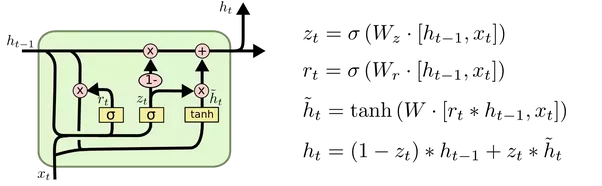

* Unidade de Memória de Longo Prazo (LSTM): - Aqui são apresentados mais 2 portas (Forget e Output), além da porta Update do GRU. E, novamente, como acima, essas são operações matemáticas adicionais nas mesmas entradas (xt e ht-1). Então, no geral, a LSTM introduziu 2 operações matemáticas com 2 novos conjuntos de pesos.

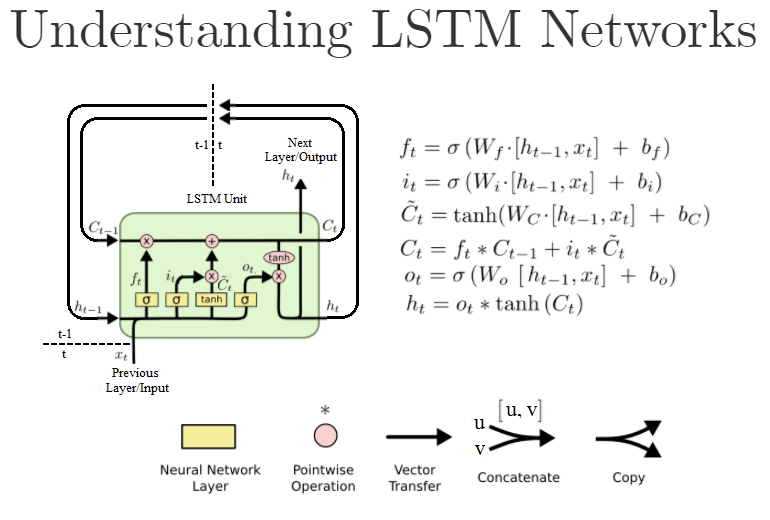

[RNN Univariada](https://github.com/xRAFPx/AAII/blob/master/RNN_Univariate.ipynb)

# Multivariada

Foi feita uma análise multivariada com modelos RNN (GRU, LSTM e SimpleRNN) por serem os modelos que, na maioria dos documentos cientificos, serem os modelos que apresentam os melhores resultados em séries temporais multivariadas.

Como os dados dos casos confirmados de COVID dependem dos dados dos óbitos, decidi seguir esta abordagem inserindo também dados da temperatura (média da máxima e mínima).



## Redes Neuronais Recorrentes - Recorrent Neural Networks (RNN)

[RNN Multivariada](https://github.com/xRAFPx/AAII/blob/master/RNN_Multivariate.ipynb)

# **Conclusões**

Os modelos SARIMA, SVR e RNN são usados em muitos problemas de séries temporais. 

A ideia deste trabalho prendeu-se com a análise de vários tipos de modelos: clássicos (SARIMA), Machine Learning (SVM) e Deep Learning (RNN).

O maior foco foi na previsão univariada de novos casos por se tratar de uma previsão fácil de analisar e estudar os modelos.

No caso do problema do COVID, por haver muitos fatores que influenciam o problema (por exemplo, as medidas de distânciamento social e de saúde pública) é dificil ao modelo conseguir fazer boas previsões e ter valores baixos de erro (medida a analisar).
O modelo SVR teve bons resultados de previsão, aproximando-se bastante dos resultados reais e obtendo, portanto, um baixo valor de erro.

Sendo que um fator determinante para o sucesso de Deep Learning é a disponibilidade de dados em larga escala em que para problemas com poucos dados, outros modelos podem dar resultados mais consistentes com menor esforço computacional, como foi o caso com o SARIMA e SVR.

RNN poderiam ser a solução para o problema se conseguissemos ter mais dados relativos ao COVID (desde mais *features* como mais dias para análise) porque redes neuronais têm muito bons resultados quando têm muitos dados. Se fossem partilhados dados como a idade dos infetados, visto que houve uma tendência à cerca de 1/2 meses de infetações em lares e atualmente existe uma maior prevalência em casos de pessoas mais jovens, poderia ser feita uma análise mais detalhada dos casos por região e obter melhores resultados nas previsões.

In [ ]:
# !git add "/content/AAII"
# !git commit -m "updated data folder"

In [ ]:
# !git push origin master

BIBLIOGRAFIA
*   https://medium.com/@navan0/how-to-push-files-into-github-from-google-colab-379fd0077aa8
*   https://www.interviewqs.com/ddi_code_snippets/extract_month_year_pandas
*   https://www.dataquest.io/blog/python-datetime-tutorial/
*   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
*   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html
*   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.PeriodIndex.html
*   http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
*https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
*https://medium.com/datadriveninvestor/hyperparameter-tuning-with-deep-learning-grid-search-8630aa45b2da
*https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/
